In [3]:
from torch import nn
import torch
from sklearn.metrics import cohen_kappa_score, calinski_harabasz_score
from ica_benchmark.split.split import Splitter
from ica_benchmark.io.load import Dataset, OpenBMI_Dataset, BCI_IV_Comp_Dataset
from pathlib import Path
from sklearn.model_selection import KFold
from lightning.pytorch import LightningModule
bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')

dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)
device = "cpu"

In [4]:
from ica_benchmark.models import EEGNet, ShallowConvNet, DeepConvNet
from ica_benchmark.models.utils import PoolParams, get_n_params
from torchsummary import summary

In [10]:
f1 = 4
d = 2
f2 = f1 * d
n_channels = 22
length = 256
n_classes = 4

shape = (1, n_channels, 256)
model = EEGNet(n_channels, n_classes, length, f1=f1, d=d, f2=f2).to("cpu").float()
x = torch.rand(100, 1, n_channels, length)
r = model.forward(x)
# display(model)

print(get_n_params(model))
summary(model, input_size=shape, device="cpu")


924
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
       BatchNorm2d-4            [-1, 8, 1, 256]              16
               ELU-5            [-1, 8, 1, 256]               0
         AvgPool2d-6             [-1, 8, 1, 64]               0
           Dropout-7             [-1, 8, 1, 64]               0
            Conv2d-8             [-1, 8, 1, 64]             128
            Conv2d-9             [-1, 8, 1, 64]              64
  SeparableConv2d-10             [-1, 8, 1, 64]               0
      BatchNorm2d-11             [-1, 8, 1, 64]              16
              ELU-12             [-1, 8, 1, 64]               0
        AvgPool2d-13              [-1, 8, 1, 8]               0
          Dropout-14              [

In [9]:
length = 512
model = EEGNet(n_channels, n_classes, length, f1=f1, d=d, f2=f2).to("cpu").float()


x = torch.rand(100, 1, n_channels, length)
print(x.shape)
output = model.first_block_top(x)
print(0, output.shape)
output = model.first_block_bottom(output)
print(1, output.shape)
output = model.second_block(output)
print(2, output.shape)
output = model.classifier.flatten(output)
print(3, output.shape)
output = model.classifier.linear(output)
print(4, output.shape)

torch.Size([100, 1, 22, 512])
0 torch.Size([100, 8, 1, 512])
1 torch.Size([100, 8, 1, 128])
2 torch.Size([100, 8, 1, 16])
3 torch.Size([100, 128])
4 torch.Size([100, 4])


In [8]:
model.classifier.linear.weight.shape, output.shape

(torch.Size([4, 144]), torch.Size([100, 4]))

In [4]:
    
length = 256
shape = (1, 1, 22, length)
model = DeepConvNet(
    22,
    4,
    length,
    temporal_filters_length=5,
    max_pool_1=PoolParams((1, 2), (1, 2)),
    max_pool_2=PoolParams((1, 2), (1, 2)),
    max_pool_3=PoolParams((1, 2), (1, 2)),
    max_pool_4=PoolParams((1, 2), (1, 2)),
    conv_length_2=5,
    conv_length_3=5,
    conv_length_4=5,
).to("cpu").float()
r = model.forward(torch.rand(*shape))
# display(model)
print(get_n_params(model))
r.shape

155854


torch.Size([1, 4])

In [28]:
length = 256
n_channels = 22

model = DeepConvNet(
    n_channels,
    4,
    length,
    temporal_filters_length=5,
    max_pool_1=PoolParams((1, 2), (1, 2)),
    max_pool_2=PoolParams((1, 2), (1, 2)),
    max_pool_3=PoolParams((1, 2), (1, 2)),
    max_pool_4=PoolParams((1, 2), (1, 2)),
    conv_length_2=5,
    conv_length_3=5,
    conv_length_4=5,
).to("cpu").float()

x = torch.rand(100, 1, n_channels, length)

self = model

layers = [
#     model.conv_pool_block_1,
    model.conv_pool_block_1.temporal_filter,
    model.conv_pool_block_1.spatial_filter,
    model.conv_pool_block_1.max_pool,
    model.conv_pool_block_2.conv,
    model.conv_pool_block_2.max_pool,
    model.conv_pool_block_3.conv,
    model.conv_pool_block_3.max_pool,
    model.conv_pool_block_4.conv,
    model.conv_pool_block_4.max_pool,
    model.classifier
]

output = x
print(output.shape)
for i, layer in enumerate(layers):
    output = layer(output)
    print(i, output.shape)

torch.Size([100, 1, 22, 256])
0 torch.Size([100, 25, 22, 252])
1 torch.Size([100, 25, 1, 252])
2 torch.Size([100, 25, 1, 126])
3 torch.Size([100, 50, 1, 122])
4 torch.Size([100, 50, 1, 61])
5 torch.Size([100, 100, 1, 57])
6 torch.Size([100, 100, 1, 28])
7 torch.Size([100, 200, 1, 24])
8 torch.Size([100, 200, 1, 12])
9 torch.Size([100, 4])


In [5]:
length = 256
shape = (1, 1, 22, length)
model = ShallowConvNet(
    22,
    4,
    length,
    temporal_filters_length=13,
    avg_pool_params=PoolParams((1, 35), (1, 7))
).to("cpu").float()
r = model.forward(torch.rand(*shape))
# display(model)
print(get_n_params(model))
r.shape

40644


torch.Size([1, 4])

In [7]:
import pandas as pd

In [7]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import lightning.pytorch as pl

x = torch.rand(100, 1, n_channels, length).to(device)
y = np.random.randint(0, 4, size=(100, ))
y = torch.from_numpy(y)
# y = torch.nn.functional.one_hot(y)
y = y.to(device)

def read_log(path):
    df = pd.read_csv(path)
    val_lines = df.dropna(subset=["train_loss"]).dropna(axis=1)
    train_lines = df.dropna(subset=["val_loss"]).dropna(axis=1)
    df = val_lines.merge(train_lines, on=["epoch", "step"], how="outer")
    return df

def get_trainer(experiment_name):
    trainer = pl.Trainer(
        default_root_dir="./training",
        callbacks=[
            ModelCheckpoint(
                monitor="val_loss",
                mode="min",
                every_n_epochs=1,
            ),
            EarlyStopping(
                monitor="val_loss",
                min_delta=1e-3,
                patience=100,
                verbose=False,
                mode="min"
            )
        ],
        deterministic=True,
        check_val_every_n_epoch=3,
        accelerator="gpu",
        logger=pl.loggers.CSVLogger(
            "./logs",
            name=experiment_name,
            version="experiment"
        ),
        max_epochs=20
    )
    return trainer

model_eegnet = EEGNet(n_channels, 4, length, f1=f1, d=d).to(device)
model_dcnet = DeepConvNet(
    22,
    4,
    length,
    temporal_filters_length=5,
    max_pool_1=PoolParams((1, 2), (1, 2)),
    max_pool_2=PoolParams((1, 2), (1, 2)),
    max_pool_3=PoolParams((1, 2), (1, 2)),
    max_pool_4=PoolParams((1, 2), (1, 2)),
    conv_length_2=5,
    conv_length_3=5,
    conv_length_4=5,
).to(device)
model_scnet =  ShallowConvNet(
    22,
    4,
    length,
    temporal_filters_length=13,
    avg_pool_params=PoolParams((1, 35), (1, 7)),
).to(device)

eegnet_trainer = get_trainer("eegnet")
dcnet_trainer = get_trainer("dcnet")
scnet_trainer = get_trainer("scnet")

model_eegnet.set_trainer(eegnet_trainer)
model_dcnet.set_trainer(dcnet_trainer)
model_scnet.set_trainer(scnet_trainer)

x, y = x.to(device), y.to(device)
# Dataset
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=10)

model_eegnet.fit(dataloader, dataloader)
model_dcnet.fit(dataloader, dataloader)
model_scnet.fit(dataloader, dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./logs/eegnet/experiment/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type       | Params
--------------------------------------------------
0 | depthwiseconv2d    | Conv2d     | 176   
1 | first_block_top    | Sequential | 440   
2 | first_block_bottom 

Sanity Checking: 0it [00:00, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (10) is small

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./logs/dcnet/experiment/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | conv_pool_block_1 | Sequential | 14.0 K
1 | conv_pool_block_2 | Sequential | 6.4 K 
2 | conv_pool_block_3 | Sequential | 25.3 K
3 | conv_pool_block_4 | Sequential | 100 K 
4 | _extractor        | Sequential | 146 K 
5 | classifier        | Sequential | 9.6 K 
6 | dropout_1         | Dropout    | 0     
7 | dropout_2         | Dropout    | 0     
8 | dropout_3         | Dropout    | 0     
9 | dropout_4         | Dropout    | 0     
-------------------------------------------------
155 K     Trainable params
0      

Sanity Checking: 0it [00:00, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (10) is small

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./logs/scnet/experiment/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | conv_block | Sequential | 35.8 K
1 | pool       | AvgPool2d  | 0     
2 | _extractor | Sequential | 35.8 K
3 | classifier | Sequential | 4.8 K 
4 | dropout_1  | Dropout    | 0     
5 | dropout_2  | Dropout    | 0     
6 | dropout_3  | Dropout    | 0     
7 | dropout_4  | Dropout    | 0     
------------------------------------------
40.6 K    Trainable params
0         Non-trainable params
40.6 K    Total params
0.163     Total estimated model params size (MB)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarni

Sanity Checking: 0it [00:00, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (10) is small

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
read_log("./logs/eegnet/experiment/metrics.csv")

train_cohen_kappa_score  train_balanced_accuracy_score  train_micro_f1  \
0                  0.017199                       0.260870            0.28   
1                  0.028329                       0.263846            0.29   
2                  0.017199                       0.262811            0.28   
3                 -0.015507                       0.245989            0.26   
4                  0.037271                       0.274715            0.30   
5                  0.147063                       0.354167            0.38   
6                  0.077770                       0.305383            0.33   
7                  0.134259                       0.341097            0.37   
8                  0.131873                       0.343038            0.37   
9                  0.076372                       0.303442            0.33   
10                 0.142699                       0.344203            0.38   
11                 0.116998                       0.330357            0.36   
12                 0.132470                       0.336180            0.37   
13                 0.163123                       0.367883            0.39   
14                 0.116144                       0.331263            0.36   
15                 0.171614                       0.368918            0.40   
16                 0.188557                       0.380694            0.41   
17                 0.217892                       0.401786            0.43   
18                 0.239234                       0.430254            0.44   
19                 0.292324                       0.468038            0.48   

    train_micro_precision  train_micro_recall  train_loss  epoch  step  \
0                    0.28                0.28    1.387588      0     9   
1                    0.29                0.29    1.383247      1    19   
2                    0.28                0.28    1.374962      2    29   
3                    0.26                0.26    1.381839      3    39   
4                    0.30                0.30    1.370870      4    49   
5                    0.38                0.38    1.349454      5    59   
6                    0.33                0.33    1.366649      6    69   
7                    0.37                0.37    1.360631      7    79   
8                    0.37                0.37    1.346673      8    89   
9                    0.33                0.33    1.351035      9    99   
10                   0.38                0.38    1.356483     10   109   
11                   0.36                0.36    1.359546     11   119   
12                   0.37                0.37    1.335745     12   129   
13                   0.39                0.39    1.317904     13   139   
14                   0.36                0.36    1.316147     14   149   
15                   0.40                0.40    1.309038     15   159   
16                   0.41                0.41    1.299891     16   169   
17                   0.43                0.43    1.324693     17   179   
18                   0.44                0.44    1.288831     18   189   
19                   0.48                0.48    1.248082     19   199   

    val_cohen_kappa_score  val_balanced_accuracy_score  val_micro_f1  \
0                     NaN                          NaN           NaN   
1                     NaN                          NaN           NaN   
2                0.042332                     0.276786          0.31   
3                     NaN                          NaN           NaN   
4                     NaN                          NaN           NaN   
5                0.125000                     0.330357          0.37   
6                     NaN                          NaN           NaN   
7                     NaN                          NaN           NaN   
8                0.256301                     0.427407          0.46   
9                     NaN                          NaN           NaN   
10                

In [9]:
read_log("./logs/dcnet/experiment/metrics.csv")

train_cohen_kappa_score_x  train_balanced_accuracy_score_x  \
0                  -0.002167                         0.245989   
1                  -0.051780                         0.216097   
2                  -0.029549                         0.241718   

   train_micro_f1_x  train_micro_precision_x  train_micro_recall_x  \
0              0.26                     0.26                  0.26   
1              0.22                     0.22                  0.22   
2              0.23                     0.23                  0.23   

   train_loss_x  epoch  step  train_cohen_kappa_score_y  \
0      1.684546      0     9                        NaN   
1      1.591650      1    19                        NaN   
2      1.549074      2    29                        NaN   

   train_balanced_accuracy_score_y  train_micro_f1_y  train_micro_precision_y  \
0                              NaN               NaN                      NaN   
1                              NaN               NaN                      NaN   
2                              NaN               NaN                      NaN   

   train_micro_recall_y  train_loss_y  val_cohen_kappa_score  \
0                   NaN           NaN                    NaN   
1                   NaN           NaN                    NaN   
2                   NaN           NaN                    NaN   

   val_balanced_accuracy_score  val_micro_f1  val_micro_precision  \
0                          NaN           NaN                  NaN   
1                          NaN           NaN                  NaN   
2                          NaN           NaN                  NaN   

   val_micro_recall  val_loss  
0               NaN       NaN  
1               NaN       NaN  
2               NaN       NaN

In [10]:
read_log("./logs/scnet/experiment/metrics.csv")

train_cohen_kappa_score_x  train_balanced_accuracy_score_x  \
0                   0.071741                         0.299301   
1                   0.825994                         0.866201   
2                   0.879727                         0.912785   

   train_micro_f1_x  train_micro_precision_x  train_micro_recall_x  \
0              0.30                     0.30                  0.30   
1              0.87                     0.87                  0.87   
2              0.91                     0.91                  0.91   

   train_loss_x  epoch  step  train_cohen_kappa_score_y  \
0      1.387768      0     9                        NaN   
1      1.076465      1    19                        NaN   
2      0.809142      2    29                        NaN   

   train_balanced_accuracy_score_y  train_micro_f1_y  train_micro_precision_y  \
0                              NaN               NaN                      NaN   
1                              NaN               NaN                      NaN   
2                              NaN               NaN                      NaN   

   train_micro_recall_y  train_loss_y  val_cohen_kappa_score  \
0                   NaN           NaN                    NaN   
1                   NaN           NaN                    NaN   
2                   NaN           NaN                    NaN   

   val_balanced_accuracy_score  val_micro_f1  val_micro_precision  \
0                          NaN           NaN                  NaN   
1                          NaN           NaN                  NaN   
2                          NaN           NaN                  NaN   

   val_micro_recall  val_loss  
0               NaN       NaN  
1               NaN       NaN  
2               NaN       NaN

In [11]:
expected_sizes = {
    "first_block_top.conv2d.weight": f1 * 64,
    "first_block_top.batchnorm.weight": f1,
    "first_block_top.first_block_top.bias": f1,
    "first_block_top.depthwiseconv2d.weight": n_channels * d * f1,
   
    "first_block_bottom.batchnorm.weight": f1 * d,
    "first_block_bottom.batchnorm.bias": f1 * d,
    
    "second_block.separableconv2d.depthwise_layer.weight": 16 * d * f1,
    "second_block.separableconv2d.pointwise_layer.weight": f2 * d * f1,
    "second_block.batchnorm.weight": f2,
    "second_block.batchnorm.bias": f2,
    
    "classifier.linear.weight": n_classes * f2 * length // 32,
    "classifier.linear.bias": n_classes,
}

sum(expected_sizes.values())

924

In [12]:
from math import prod
model = model_eegnet
print("F1 =", model.f1)
print("F2 =", model.f2)
print("D =", model.d)
print()

total_params = 0
for name, params in model.named_parameters():
    shape = params.shape
    n_params = prod(shape)
    
    warn_msg = ""
    expected_size = None
    if name in expected_sizes:
        expected_size = expected_sizes[name]
        if expected_sizes[name] != n_params:
            warn_msg = "[WRONG]"
        
    print(warn_msg, name)
    print("\tShape:", " * ".join(map(str, shape)))
    print("\t# Params / Expected: {} / {}".format(n_params, expected_size))
    print()
    total_params += n_params
total_params

F1 = 4
F2 = 8
D = 2

 depthwiseconv2d.weight
	Shape: 8 * 1 * 22 * 1
	# Params / Expected: 176 / None

 first_block_top.conv2d.weight
	Shape: 4 * 1 * 1 * 64
	# Params / Expected: 256 / 256

 first_block_top.batchnorm.weight
	Shape: 4
	# Params / Expected: 4 / 4

 first_block_top.batchnorm.bias
	Shape: 4
	# Params / Expected: 4 / None

 first_block_bottom.batchnorm.weight
	Shape: 8
	# Params / Expected: 8 / 8

 first_block_bottom.batchnorm.bias
	Shape: 8
	# Params / Expected: 8 / 8

 second_block.separableconv2d.depthwise_layer.weight
	Shape: 8 * 1 * 1 * 16
	# Params / Expected: 128 / 128

 second_block.separableconv2d.pointwise_layer.weight
	Shape: 8 * 8 * 1 * 1
	# Params / Expected: 64 / 64

 second_block.batchnorm.weight
	Shape: 8
	# Params / Expected: 8 / 8

 second_block.batchnorm.bias
	Shape: 8
	# Params / Expected: 8 / 8

 classifier.linear.weight
	Shape: 4 * 64
	# Params / Expected: 256 / 256

 classifier.linear.bias
	Shape: 4
	# Params / Expected: 4 / 4



924

In [13]:

def copy_as_raw(raw, data):
    """Aux method."""
    # merge copied instance and picked data with sources
    data_ = data
#     assert data_.shape[1] == stop - start

    preloaded = raw.preload
    if preloaded:
        # get data and temporarily delete
        data = raw._data
        raw.preload = False
        del raw._data
    # copy and crop here so that things like annotations are adjusted
    out = raw.copy()

    out._data = data_
    out._first_samps = [out.first_samp]
    out._last_samps = [out.last_samp]
    out._filenames = [None]
    out.preload = True
    out._projector = None
    return out



In [14]:
from tqdm.notebook import tqdm
import numpy as np
import mne

# https://github.com/TNTLFreiburg/braindecode/blob/d9feb5c6cfcd203fa8daa79ccd3217712714f330/braindecode/mne_ext/signalproc.py#L75
def apply_raw(func, raw, verbose="WARNING"):
    """
    Apply function to data of `mne.io.RawArray`.
    
    Parameters
    ----------
    func: function
        Should accept 2d-array (channels x time) and return modified 2d-array
    raw: `mne.io.RawArray`
    verbose: bool
        Whether to log creation of new `mne.io.RawArray`.
    Returns
    -------
    transformed_set: Copy of `raw` with data transformed by given function.
    """
    new_data = func(raw.get_data())
    new_raw = copy_as_raw(raw, new_data)
    return new_raw


def exponential_standardize(data, start=1000, eps=1e-4, alpha=1e-3):
    # https://arxiv.org/pdf/1703.05051.pdf
    # data: n_channels, n_times
    # Make sure data is sampled at 250Hz! Default values expect it!
    mean = data[:, :start].mean(axis=1, keepdims=True)
    var = data[:, :start].var(axis=1, keepdims=True)
    
    N = data.shape[1]
    new_data = data.copy()
    new_data[:, :start] -= (new_data[:, :start] - mean) / np.maximum(np.sqrt(var), eps)

    for idx in tqdm(range(start, N)):
        x_t = new_data[:, [idx]]
        mean = alpha * x_t + (1 - alpha) * mean
        var = alpha  * (x_t - mean) ** 2 + (1 - alpha) * var        
        new_data[:, [idx]] = (x_t - mean) / np.maximum(np.sqrt(var), eps)
    return new_data

# raw = dataset.load_as_raw(filepath)
# new_data = exponential_standardize(raw.get_data())

In [15]:
import scipy.signal
# https://github.com/robintibor/braindecode/blob/master/braindecode/datautil/signalproc.py#L127-L154
    
def filter_is_stable(a):
    """
    Check if filter coefficients of IIR filter are stable.
    
    Parameters
    ----------
    a: list or 1darray of number
        Denominator filter coefficients a.
    Returns
    -------
    is_stable: bool
        Filter is stable or not.  
    Notes
    ----
    Filter is stable if absolute value of all  roots is smaller than 1,
    see [1]_.
    
    References
    ----------
    .. [1] HYRY, "SciPy 'lfilter' returns only NaNs" StackOverflow,
       http://stackoverflow.com/a/8812737/1469195
    """
    assert a[0] == 1.0, (
        "a[0] should normally be zero, did you accidentally supply b?\n"
        "a: {:s}".format(str(a))
    )
    # from http://stackoverflow.com/a/8812737/1469195
    return np.all(np.abs(np.roots(a)) < 1)

def highpass_cnt(data, low_cut_hz, fs, filt_order=3, axis=0):
    """
     Highpass signal applying **causal** butterworth filter of given order.
    Parameters
    ----------
    data: 2d-array
        Time x channels
    low_cut_hz: float
    fs: float
    filt_order: int
    Returns
    -------
    highpassed_data: 2d-array
        Data after applying highpass filter.
    """
    if (low_cut_hz is None) or (low_cut_hz == 0):
        log.info("Not doing any highpass, since low 0 or None")
        return data.copy()
    b, a = scipy.signal.butter(
        filt_order, low_cut_hz / (fs / 2.0), btype="highpass"
    )
    assert filter_is_stable(a)
    data_highpassed = scipy.signal.lfilter(b, a, data, axis=axis)
    return data_highpassed


def lowpass_cnt(data, high_cut_hz, fs, filt_order=3, axis=0):
    """
     Lowpass signal applying **causal** butterworth filter of given order.
    Parameters
    ----------
    data: 2d-array
        Time x channels
    high_cut_hz: float
    fs: float
    filt_order: int
    Returns
    -------
    lowpassed_data: 2d-array
        Data after applying lowpass filter.
    """
    if (high_cut_hz is None) or (high_cut_hz == fs / 2.0):
        log.info(
            "Not doing any lowpass, since high cut hz is None or nyquist freq."
        )
        return data.copy()
    b, a = scipy.signal.butter(
        filt_order, high_cut_hz / (fs / 2.0), btype="lowpass"
    )
    assert filter_is_stable(a)
    data_lowpassed = scipy.signal.lfilter(b, a, data, axis=axis)
    return data_lowpassed


def bandpass_cnt(
    data, low_cut_hz=4., high_cut_hz=38., fs=250., filt_order=3, axis=1, filtfilt=False
):
    """
     Bandpass signal applying **causal** butterworth filter of given order.
    Parameters
    ----------
    data: 2d-array
        Channels x times
    low_cut_hz: float
    high_cut_hz: float
    fs: float
    filt_order: int
    filtfilt: bool
        Whether to use filtfilt instead of lfilter
    Returns
    -------
    bandpassed_data: 2d-array
        Data after applying bandpass filter.
    """
    n_channels, n_times = data.shape
    assert n_channels < n_times
    
    if (low_cut_hz == 0 or low_cut_hz is None) and (
        high_cut_hz == None or high_cut_hz == fs / 2.0
    ):
        log.info(
            "Not doing any bandpass, since low 0 or None and "
            "high None or nyquist frequency"
        )
        return data.copy()
    if low_cut_hz == 0 or low_cut_hz == None:
        log.info("Using lowpass filter since low cut hz is 0 or None")
        return lowpass_cnt(
            data, high_cut_hz, fs, filt_order=filt_order, axis=axis
        )
    if high_cut_hz == None or high_cut_hz == (fs / 2.0):
        log.info(
            "Using highpass filter since high cut hz is None or nyquist freq"
        )
        return highpass_cnt(
            data, low_cut_hz, fs, filt_order=filt_order, axis=axis
        )

    nyq_freq = 0.5 * fs
    low = low_cut_hz / nyq_freq
    high = high_cut_hz / nyq_freq
    b, a = scipy.signal.butter(filt_order, [low, high], btype="bandpass")
    assert filter_is_stable(a), "Filter should be stable..."
    if filtfilt:
        data_bandpassed = scipy.signal.filtfilt(b, a, data, axis=axis)
    else:
        data_bandpassed = scipy.signal.lfilter(b, a, data, axis=axis)
    return data_bandpassed



In [16]:
def process_raw_fn(data):
    # https://arxiv.org/pdf/1703.05051.pdf
    # First the bandpass, them the exp stand
    data = bandpass_cnt(data, low_cut_hz=4., high_cut_hz=38., fs=128., filtfilt=False)
#     data = exponential_standardize(data)

    return data

In [ ]:
import numpy as np
import mne
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch import nn
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ica_benchmark.processing.ica import get_ica_instance
from copy import deepcopy
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)
random_state = 1

mne.set_log_level(0)
bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')
# raw_fn = lambda raw: apply_raw(exponential_standardize, raw)

def raw_fn(raw):
    return apply_raw(
        process_raw_fn,
        raw.copy().resample(128)
    )

dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)

fold_sizes = None

splitter = Splitter(
    dataset,
    uids=dataset.list_uids(),
#     uids=["8"],
    sessions=dataset.SESSIONS,
    runs=dataset.RUNS,
    load_kwargs=dict(
        reject=False,
        tmin=0.5,
        tmax=2.6,
        raw_fn=raw_fn,
        concatenate=False
    ),
    splitter=KFold(4),
    intra_session_shuffle=False,
    fold_sizes=fold_sizes,
)

splits_iterable = splitter.yield_splits_epochs(mode="inter_session")
results = list()
for i, fold_splits in enumerate(splits_iterable):
    
    uid = fold_splits[0]["uid"][0]
    
    train_epochs, test_epochs = splitter.load_from_splits(fold_splits, fold_sizes=None)
    if isinstance(train_epochs, (list, tuple)):
        train_epochs = train_epochs[0].load_data()
        test_epochs = test_epochs[0].load_data()
        
    n_channels = len(train_epochs.ch_names)

    train_data = train_epochs.copy().get_data()[..., :256]
    test_data = test_epochs.copy().get_data()[..., :256]
    train_labels = train_epochs.events[:, 2]
    test_labels = test_epochs.events[:, 2]
    
    del train_epochs, test_epochs


    train_data = np.expand_dims(train_data, axis=1)
    test_data = np.expand_dims(test_data, axis=1)
    
    train_data, train_labels = torch.from_numpy(train_data).float(), torch.from_numpy(train_labels).to(dtype=torch.int64)
    test_data, test_labels = torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).to(dtype=torch.int64)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=.25, random_state=random_state)
    
    train_data.to(device), train_labels.to(device)
    val_data.to(device), val_labels.to(device)
    test_data.to(device), test_labels.to(device)
    
    train_dataloader = DataLoader(
        TensorDataset(train_data, train_labels),
        batch_size=16,
        shuffle=True
    )
    val_dataloader = DataLoader(
        TensorDataset(val_data, val_labels),
        batch_size=16,
        shuffle=True
    )
    test_dataloader = DataLoader(
        TensorDataset(test_data, test_labels),
        batch_size=16,
        shuffle=True
    )
    
    torch.manual_seed(random_state)
    
    for model, name in zip([model_eegnet, model_dcnet, model_scnet], ["eegnet", "dcnet", "scnet"]):
        model.set_trainer(get_trainer(name))
        model.fit(train_dataloader, val_dataloader)
        model.test(test_dataloader)
    
    
    

In [28]:
def get_trainer(experiment_name):
    trainer = pl.Trainer(
        default_root_dir="./training",
        callbacks=[
            ModelCheckpoint(
                monitor="val_loss",
                mode="min",
                every_n_epochs=1,
            ),
            EarlyStopping(
                monitor="val_loss",
                min_delta=1e-3,
                patience=100,
                verbose=False,
                mode="min"
            )
        ],
        deterministic=True,
        check_val_every_n_epoch=5,
        accelerator="gpu",
        logger=pl.loggers.CSVLogger(
            "./logs",
            name=experiment_name,
            version="experiment"
        ),
        max_epochs=1000
    )
    return trainer
model_eegnet = EEGNet(n_channels, 4, length, f1=f1, d=d).to(device)
model_eegnet.set_trainer(get_trainer("eegnet"))

model_eegnet.fit(train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type       | Params
--------------------------------------------------
0 | depthwiseconv2d    | Conv2d     | 176   
1 | first_block_top    | Sequential | 440   
2 | first_block_bottom | Sequential | 16    
3 | second_block       | Sequential | 208   
4 | classifier         | Sequential | 260   
--------------------------------------------------
924       Trainable params
0         Non-trainable params
924       Total params
0.004     Total estimated model params size (MB)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory ./logs/eegnet/experiment exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [35]:
model_eegnet.test(test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_balanced_accuracy_score │      0.2465277777777778      │
│    test_cohen_kappa_score    │    -0.004629629629629539     │
│        test_micro_f1         │      0.2465277777777778      │
│     test_micro_precision     │      0.2465277777777778      │
│      test_micro_recall       │      0.2465277777777778      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_cohen_kappa_score': -0.004629629629629539,
  'test_balanced_accuracy_score': 0.2465277777777778,
  'test_micro_f1': 0.2465277777777778,
  'test_micro_precision': 0.2465277777777778,
  'test_micro_recall': 0.2465277777777778}]

In [33]:
train_labels

tensor([0, 3, 0, 2, 0, 1, 3, 0, 3, 1, 0, 0, 0, 3, 0, 1, 0, 2, 0, 2, 1, 3, 1, 0,
        3, 2, 0, 0, 0, 0, 1, 2, 0, 2, 2, 1, 2, 3, 1, 3, 3, 1, 0, 3, 2, 2, 2, 3,
        3, 0, 1, 0, 2, 2, 2, 0, 1, 2, 1, 3, 3, 3, 2, 3, 2, 1, 2, 1, 3, 1, 0, 2,
        1, 0, 2, 0, 1, 2, 3, 0, 0, 1, 2, 0, 1, 3, 0, 2, 0, 2, 0, 3, 3, 3, 2, 2,
        3, 2, 0, 2, 0, 2, 2, 3, 3, 3, 1, 3, 1, 0, 1, 2, 0, 3, 3, 1, 3, 3, 1, 2,
        2, 1, 1, 1, 3, 2, 3, 0, 2, 3, 3, 1, 3, 3, 2, 1, 2, 1, 2, 0, 1, 0, 3, 0,
        3, 1, 3, 1, 1, 2, 1, 0, 2, 1, 2, 0, 1, 2, 0, 2, 3, 2, 0, 0, 0, 2, 3, 1,
        3, 1, 1, 2, 3, 1, 2, 0, 3, 0, 2, 2, 0, 3, 0, 3, 0, 0, 1, 1, 3, 3, 3, 1,
        2, 3, 3, 0, 3, 3, 2, 0, 3, 1, 0, 1, 3, 0, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2])

<AxesSubplot:>

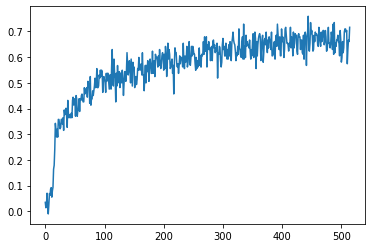

In [54]:
read_log("logs/eegnet/experiment/metrics.csv").train_cohen_kappa_score.dropna().plot()

In [48]:
model_eegnet.training

True

In [51]:
cohen_kappa_score(test_labels.detach().numpy(), model_eegnet(test_data).argmax(axis=1).detach().numpy())

0.5694444444444444

In [53]:
cohen_kappa_score(val_labels.detach().numpy(), model_eegnet(val_data).argmax(axis=1).detach().numpy())

0.6853470437017994

In [20]:
model_eegnet = EEGNet(n_channels, 3, length, f1=f1, d=d).to(device)
model_dcnet = DeepConvNet(
    22,
    4,
    length,
    temporal_filters_length=5,
    max_pool_1=PoolParams((1, 2), (1, 2)),
    max_pool_2=PoolParams((1, 2), (1, 2)),
    max_pool_3=PoolParams((1, 2), (1, 2)),
    max_pool_4=PoolParams((1, 2), (1, 2)),
    conv_length_2=5,
    conv_length_3=5,
    conv_length_4=5,
).to(device)
model_scnet =  ShallowConvNet(
    22,
    4,
    length,
    temporal_filters_length=13,
    avg_pool_params=PoolParams((1, 35), (1, 7)),
).to(device)

eegnet_trainer = get_trainer("eegnet")
dcnet_trainer = get_trainer("dcnet")
scnet_trainer = get_trainer("scnet")

model_eegnet.set_trainer(eegnet_trainer)
model_dcnet.set_trainer(dcnet_trainer)
model_scnet.set_trainer(scnet_trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 22, 256]             512
       BatchNorm2d-2           [-1, 8, 22, 256]              16
            Conv2d-3           [-1, 16, 1, 256]             352
            Conv2d-4           [-1, 16, 1, 256]             352
       BatchNorm2d-5           [-1, 16, 1, 256]              32
               ELU-6           [-1, 16, 1, 256]               0
         AvgPool2d-7            [-1, 16, 1, 64]               0
           Dropout-8            [-1, 16, 1, 64]               0
            Conv2d-9            [-1, 16, 1, 64]             256
           Conv2d-10            [-1, 16, 1, 64]             256
  SeparableConv2d-11            [-1, 16, 1, 64]               0
      BatchNorm2d-12            [-1, 16, 1, 64]              32
              ELU-13            [-1, 16, 1, 64]               0
        AvgPool2d-14             [-1, 1

128-1/100) T:0.761 -> 0.780 | V:0.937 (Best: 0.807)
129-2/100) T:0.806 -> 0.765 | V:0.950 (Best: 0.807)
130-3/100) T:0.797 -> 0.782 | V:0.813 (Best: 0.807)
131-4/100) T:0.827 -> 0.796 | V:0.949 (Best: 0.807)
132-5/100) T:0.857 -> 0.813 | V:2.274 (Best: 0.807)
133-6/100) T:0.765 -> 0.761 | V:0.862 (Best: 0.807)
134-7/100) T:0.756 -> 0.777 | V:1.179 (Best: 0.807)
135-8/100) T:0.807 -> 0.786 | V:1.637 (Best: 0.807)
136-9/100) T:0.786 -> 0.779 | V:0.803 (Best: 0.807)
137-0/100) T:0.792 -> 0.776 | V:1.853 (Best: 0.803)
138-1/100) T:0.719 -> 0.745 | V:1.080 (Best: 0.803)
139-2/100) T:0.782 -> 0.729 | V:1.749 (Best: 0.803)
140-3/100) T:0.779 -> 0.762 | V:0.856 (Best: 0.803)
141-4/100) T:0.761 -> 0.745 | V:1.003 (Best: 0.803)
142-5/100) T:0.761 -> 0.763 | V:1.917 (Best: 0.803)
143-6/100) T:0.753 -> 0.730 | V:0.814 (Best: 0.803)
144-7/100) T:0.737 -> 0.723 | V:1.395 (Best: 0.803)
145-8/100) T:0.849 -> 0.809 | V:2.691 (Best: 0.803)
146-9/100) T:0.780 -> 0.800 | V:0.979 (Best: 0.803)
147-10/100) 

284-35/100) T:0.608 -> 0.629 | V:0.819 (Best: 0.709)
285-36/100) T:0.617 -> 0.617 | V:0.695 (Best: 0.709)
286-0/100) T:0.649 -> 0.629 | V:0.689 (Best: 0.695)
287-0/100) T:0.597 -> 0.589 | V:0.783 (Best: 0.689)
288-1/100) T:0.617 -> 0.652 | V:1.754 (Best: 0.689)
289-2/100) T:0.580 -> 0.590 | V:0.780 (Best: 0.689)
290-3/100) T:0.598 -> 0.585 | V:1.026 (Best: 0.689)
291-4/100) T:0.615 -> 0.670 | V:2.220 (Best: 0.689)
292-5/100) T:0.650 -> 0.688 | V:0.879 (Best: 0.689)
293-6/100) T:0.590 -> 0.615 | V:0.707 (Best: 0.689)
294-7/100) T:0.620 -> 0.602 | V:0.686 (Best: 0.689)
295-0/100) T:0.591 -> 0.600 | V:0.890 (Best: 0.686)
296-1/100) T:0.671 -> 0.641 | V:0.752 (Best: 0.686)
297-2/100) T:0.658 -> 0.634 | V:0.758 (Best: 0.686)
298-3/100) T:0.628 -> 0.601 | V:0.885 (Best: 0.686)
299-4/100) T:0.691 -> 0.662 | V:4.063 (Best: 0.686)
300-5/100) T:0.635 -> 0.630 | V:0.838 (Best: 0.686)
301-6/100) T:0.663 -> 0.587 | V:0.784 (Best: 0.686)
302-7/100) T:0.596 -> 0.600 | V:0.984 (Best: 0.686)
303-8/100)

440-59/100) T:0.496 -> 0.509 | V:1.406 (Best: 0.663)
441-60/100) T:0.511 -> 0.477 | V:2.196 (Best: 0.663)
442-61/100) T:0.495 -> 0.486 | V:2.329 (Best: 0.663)
443-62/100) T:0.557 -> 0.575 | V:3.978 (Best: 0.663)
444-63/100) T:0.488 -> 0.498 | V:0.910 (Best: 0.663)
445-64/100) T:0.543 -> 0.504 | V:1.179 (Best: 0.663)
446-65/100) T:0.539 -> 0.481 | V:3.068 (Best: 0.663)
447-66/100) T:0.486 -> 0.493 | V:2.763 (Best: 0.663)
448-67/100) T:0.585 -> 0.559 | V:1.406 (Best: 0.663)
449-68/100) T:0.483 -> 0.468 | V:3.493 (Best: 0.663)
450-69/100) T:0.544 -> 0.508 | V:1.623 (Best: 0.663)
451-70/100) T:0.509 -> 0.469 | V:3.140 (Best: 0.663)
452-71/100) T:0.501 -> 0.457 | V:2.200 (Best: 0.663)
453-72/100) T:0.580 -> 0.509 | V:2.917 (Best: 0.663)
454-73/100) T:0.581 -> 0.571 | V:0.985 (Best: 0.663)
455-74/100) T:0.499 -> 0.503 | V:3.814 (Best: 0.663)
456-75/100) T:0.528 -> 0.494 | V:1.487 (Best: 0.663)
457-76/100) T:0.517 -> 0.520 | V:2.159 (Best: 0.663)
458-77/100) T:0.501 -> 0.504 | V:1.411 (Best: 

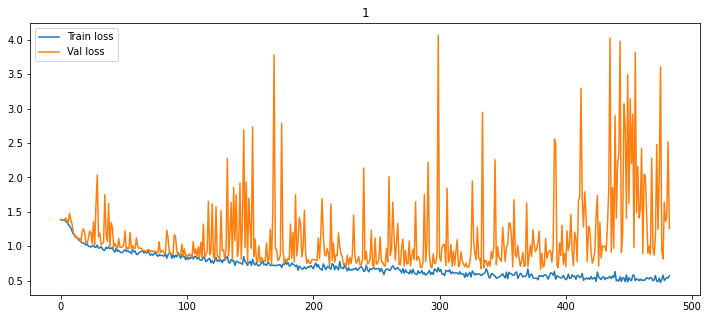

Final results Train:0.815 | Val:0.609 | Test: 0.653


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


KeyboardInterrupt: 

In [25]:
import numpy as np
import mne
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch import nn
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ica_benchmark.processing.ica import get_ica_instance
from copy import deepcopy
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)
random_state = 1

mne.set_log_level(0)
bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')
# raw_fn = lambda raw: apply_raw(exponential_standardize, raw)

def raw_fn(raw):
    return apply_raw(
        process_raw_fn,
        raw.copy().resample(128)
    )

dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)

fold_sizes = None

splitter = Splitter(
    dataset,
    uids=dataset.list_uids(),
#     uids=["8"],
    sessions=dataset.SESSIONS,
    runs=dataset.RUNS,
    load_kwargs=dict(
        reject=False,
        tmin=0.5,
        tmax=2.6,
        raw_fn=raw_fn,
        concatenate=False
    ),
    splitter=KFold(4),
    intra_session_shuffle=False,
    fold_sizes=fold_sizes,
)

splits_iterable = splitter.yield_splits_epochs(mode="inter_session")
results = list()
for i, fold_splits in enumerate(splits_iterable):
    
    uid = fold_splits[0]["uid"][0]
    
    train_epochs, test_epochs = splitter.load_from_splits(fold_splits, fold_sizes=None)
    if isinstance(train_epochs, (list, tuple)):
        train_epochs = train_epochs[0].load_data()
        test_epochs = test_epochs[0].load_data()
        
    n_channels = len(train_epochs.ch_names)

    train_data = train_epochs.copy().get_data()[..., :256]
    test_data = test_epochs.copy().get_data()[..., :256]
    train_labels = train_epochs.events[:, 2]
    test_labels = test_epochs.events[:, 2]
    
    del train_epochs, test_epochs


    train_data = np.expand_dims(train_data, axis=1)
    test_data = np.expand_dims(test_data, axis=1)
    
    train_data, train_labels = torch.from_numpy(train_data).float(), torch.from_numpy(train_labels).to(dtype=torch.int64)
    test_data, test_labels = torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).to(dtype=torch.int64)
    
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=.25, random_state=random_state)
    
    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
    torch.manual_seed(random_state)
    model = EEGNet(n_channels, 4, 256, f1=8).float()
    summary(model, input_size=(1, n_channels, 256), device="cpu")
    
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    best_state = None
    best_val_loss = 1000
    patience = 0
    max_patience = 100
    min_delta = 1e-3
    
    train_losses = list()
    val_losses = list()
    for epoch in range(1000):
        
        optim = Adam(model.parameters(), lr=1e-3)
        
        epoch_loss = 0
        epoch_loss_after_norm = 0
        model.train()
        for batch_number, (batch_x, batch_y) in enumerate(train_dataloader):
            optim.zero_grad()
            
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            epoch_loss += loss.item() / len(train_dataloader)

            loss.backward()
            optim.step()
            
            # Projection to norm constraints
            model.apply_constraints()
            
            epoch_loss_after_norm += criterion(model(batch_x), batch_y).item() / len(train_dataloader)

        model.eval()
        val_loss = criterion(
            model(val_data),
            val_labels
        ).item()

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        
        print("{}-{}/{}) T:{:.3f} -> {:.3f} | V:{:.3f} (Best: {:.3f})".format(epoch, patience, max_patience, epoch_loss, epoch_loss_after_norm, val_loss, best_val_loss))
        
        if (best_val_loss - val_loss) > min_delta:
            best_state = deepcopy(model.state_dict())
            best_val_loss = val_loss
            patience = 0
        elif patience > max_patience:
            break
        else:
            patience += 1
    
    model.load_state_dict(best_state)
    model.eval()
    train_kappa = cohen_kappa_score(
        train_labels,
        model(train_data).detach().numpy().argmax(axis=1)
    )
    val_kappa = cohen_kappa_score(
        val_labels,
        model(val_data).detach().numpy().argmax(axis=1)
    )
    test_kappa = cohen_kappa_score(
        test_labels,
        model(test_data).detach().numpy().argmax(axis=1)
    )
    results.append(
        dict(
            uid=uid,
            train_kappa=train_kappa,
            val_kappa=val_kappa,
            test_kappa=test_kappa,
            
        )
    )
    plt.figure(figsize=(12, 5))
    plt.title(uid)
    plt.plot(range(len(train_losses)), train_losses, label="Train loss")
    plt.plot(range(len(val_losses)), val_losses, label="Val loss")
    plt.legend()
    plt.show()

    print("Final results Train:{:.3f} | Val:{:.3f} | Test: {:.3f}".format(train_kappa, val_kappa, test_kappa))

In [265]:
import pandas as pd

pd.DataFrame.from_records(results)

uid  train_kappa  val_kappa  test_kappa
0   1     0.913575   0.702940    0.675926
1   2    -0.006662  -0.037037    0.032407
2   3     0.925628   0.905981    0.791667
3   4     0.322305   0.130077    0.180556
4   5     0.608437   0.275472    0.296296
5   6     0.684446   0.360836    0.273148
6   7     0.796314   0.602733    0.546296
7   8     0.813638   0.579695    0.583333
8   9     0.826610   0.705747    0.625000

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/343334 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/350744 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 22, 256, 1]               0
            Conv2d-2           [-1, 16, 256, 1]             368
       BatchNorm2d-3           [-1, 16, 256, 1]              32
        Expression-4           [-1, 16, 256, 1]               0
        Expression-5           [-1, 1, 16, 256]               0
           Dropout-6           [-1, 1, 16, 256]               0
            Conv2d-7           [-1, 4, 17, 225]             260
       BatchNorm2d-8           [-1, 4, 17, 225]               8
        Expression-9           [-1, 4, 17, 225]               0
        MaxPool2d-10             [-1, 4, 8, 56]               0
          Dropout-11             [-1, 4, 8, 56]               0
           Conv2d-12             [-1, 4, 9, 53]             516
      BatchNorm2d-13             [-1, 4, 9, 53]               8
       Expression-14             [-1, 4

123-28/100) T:0.418 -> 0.376 | V:0.817 (Best: 0.740)
124-29/100) T:0.394 -> 0.430 | V:0.871 (Best: 0.740)
125-30/100) T:0.392 -> 0.377 | V:0.854 (Best: 0.740)
126-31/100) T:0.411 -> 0.376 | V:0.824 (Best: 0.740)
127-32/100) T:0.364 -> 0.346 | V:0.929 (Best: 0.740)
128-33/100) T:0.339 -> 0.378 | V:0.839 (Best: 0.740)
129-34/100) T:0.331 -> 0.311 | V:0.912 (Best: 0.740)
130-35/100) T:0.313 -> 0.315 | V:0.855 (Best: 0.740)
131-36/100) T:0.343 -> 0.304 | V:0.861 (Best: 0.740)
132-37/100) T:0.434 -> 0.348 | V:0.835 (Best: 0.740)
133-38/100) T:0.344 -> 0.392 | V:0.939 (Best: 0.740)
134-39/100) T:0.332 -> 0.248 | V:1.003 (Best: 0.740)
135-40/100) T:0.410 -> 0.373 | V:1.066 (Best: 0.740)
136-41/100) T:0.319 -> 0.351 | V:0.918 (Best: 0.740)
137-42/100) T:0.369 -> 0.316 | V:0.896 (Best: 0.740)
138-43/100) T:0.362 -> 0.333 | V:0.856 (Best: 0.740)
139-44/100) T:0.338 -> 0.287 | V:0.991 (Best: 0.740)
140-45/100) T:0.329 -> 0.301 | V:0.864 (Best: 0.740)
141-46/100) T:0.324 -> 0.360 | V:0.949 (Best: 

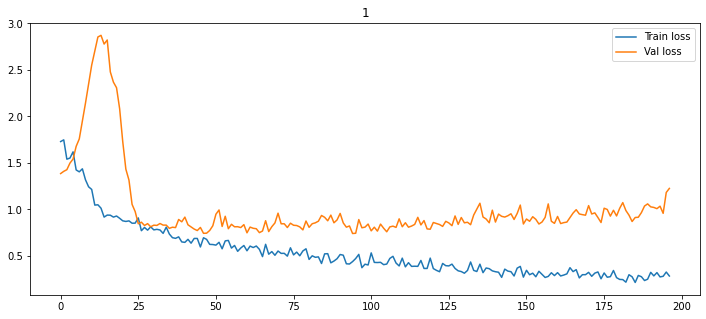

Final results Train:0.920 | Val:0.610 | Test: 0.579


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/345711 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/338285 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 22, 256, 1]               0
            Conv2d-2           [-1, 16, 256, 1]             368
       BatchNorm2d-3           [-1, 16, 256, 1]              32
        Expression-4           [-1, 16, 256, 1]               0
        Expression-5           [-1, 1, 16, 256]               0
           Dropout-6           [-1, 1, 16, 256]               0
            Conv2d-7           [-1, 4, 17, 225]             260
       BatchNorm2d-8           [-1, 4, 17, 225]               8
        Expression-9           [-1, 4, 17, 225]               0
        MaxPool2d-10             [-1, 4, 8, 56]               0
          Dropout-11             [-1, 4, 8, 56]               0
           Conv2d-12             [-1, 4, 9, 53]             516
      BatchNorm2d-13             [-1, 4, 9, 53]               8
       Expression-14             [-1, 4

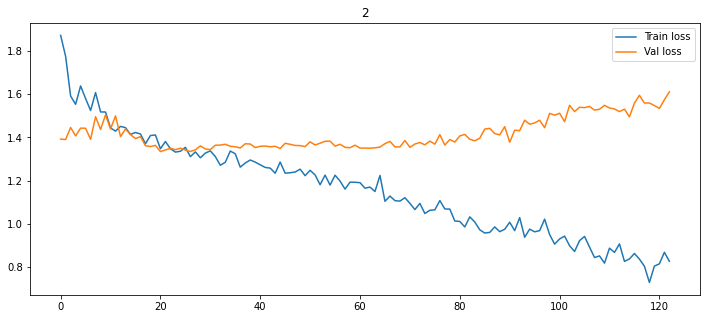

Final results Train:0.241 | Val:0.156 | Test: 0.088


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/337191 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/331173 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 22, 256, 1]               0
            Conv2d-2           [-1, 16, 256, 1]             368
       BatchNorm2d-3           [-1, 16, 256, 1]              32
        Expression-4           [-1, 16, 256, 1]               0
        Expression-5           [-1, 1, 16, 256]               0
           Dropout-6           [-1, 1, 16, 256]               0
            Conv2d-7           [-1, 4, 17, 225]             260
       BatchNorm2d-8           [-1, 4, 17, 225]               8
        Expression-9           [-1, 4, 17, 225]               0
        MaxPool2d-10             [-1, 4, 8, 56]               0
          Dropout-11             [-1, 4, 8, 56]               0
           Conv2d-12             [-1, 4, 9, 53]             516
      BatchNorm2d-13             [-1, 4, 9, 53]               8
       Expression-14             [-1, 4

124-16/100) T:0.367 -> 0.385 | V:0.819 (Best: 0.668)
125-17/100) T:0.365 -> 0.418 | V:0.758 (Best: 0.668)
126-18/100) T:0.373 -> 0.362 | V:0.856 (Best: 0.668)
127-19/100) T:0.432 -> 0.376 | V:0.764 (Best: 0.668)
128-20/100) T:0.338 -> 0.270 | V:0.755 (Best: 0.668)
129-21/100) T:0.431 -> 0.345 | V:0.790 (Best: 0.668)
130-22/100) T:0.404 -> 0.347 | V:0.714 (Best: 0.668)
131-23/100) T:0.345 -> 0.363 | V:0.700 (Best: 0.668)
132-24/100) T:0.322 -> 0.302 | V:0.829 (Best: 0.668)
133-25/100) T:0.350 -> 0.282 | V:0.701 (Best: 0.668)
134-26/100) T:0.384 -> 0.299 | V:0.714 (Best: 0.668)
135-27/100) T:0.339 -> 0.360 | V:0.834 (Best: 0.668)
136-28/100) T:0.388 -> 0.289 | V:0.718 (Best: 0.668)
137-29/100) T:0.329 -> 0.269 | V:0.760 (Best: 0.668)
138-30/100) T:0.315 -> 0.361 | V:0.725 (Best: 0.668)
139-31/100) T:0.350 -> 0.282 | V:0.783 (Best: 0.668)
140-32/100) T:0.268 -> 0.282 | V:0.800 (Best: 0.668)
141-33/100) T:0.306 -> 0.336 | V:0.746 (Best: 0.668)
142-34/100) T:0.367 -> 0.299 | V:0.824 (Best: 

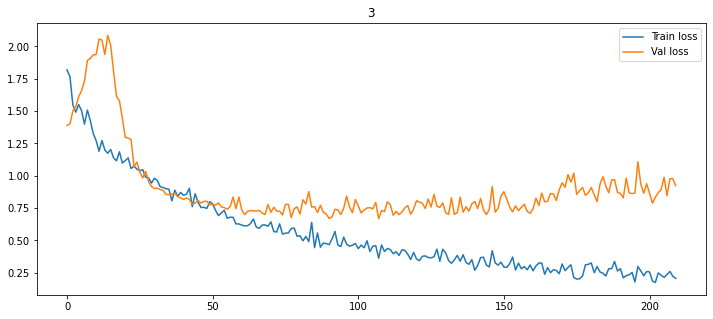

Final results Train:0.883 | Val:0.607 | Test: 0.579


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/306668 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/336944 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 22, 256, 1]               0
            Conv2d-2           [-1, 16, 256, 1]             368
       BatchNorm2d-3           [-1, 16, 256, 1]              32
        Expression-4           [-1, 16, 256, 1]               0
        Expression-5           [-1, 1, 16, 256]               0
           Dropout-6           [-1, 1, 16, 256]               0
            Conv2d-7           [-1, 4, 17, 225]             260
       BatchNorm2d-8           [-1, 4, 17, 225]               8
        Expression-9           [-1, 4, 17, 225]               0
        MaxPool2d-10             [-1, 4, 8, 56]               0
          Dropout-11             [-1, 4, 8, 56]               0
           Conv2d-12             [-1, 4, 9, 53]             516
      BatchNorm2d-13             [-1, 4, 9, 53]               8
       Expression-14             [-1, 4

123-37/100) T:0.718 -> 0.744 | V:1.642 (Best: 1.351)
124-38/100) T:0.626 -> 0.673 | V:1.809 (Best: 1.351)
125-39/100) T:0.597 -> 0.680 | V:1.803 (Best: 1.351)
126-40/100) T:0.660 -> 0.614 | V:1.797 (Best: 1.351)
127-41/100) T:0.644 -> 0.607 | V:1.706 (Best: 1.351)
128-42/100) T:0.597 -> 0.613 | V:1.758 (Best: 1.351)
129-43/100) T:0.596 -> 0.638 | V:1.830 (Best: 1.351)
130-44/100) T:0.724 -> 0.578 | V:2.065 (Best: 1.351)
131-45/100) T:0.612 -> 0.675 | V:1.737 (Best: 1.351)
132-46/100) T:0.672 -> 0.615 | V:1.831 (Best: 1.351)
133-47/100) T:0.616 -> 0.571 | V:1.919 (Best: 1.351)
134-48/100) T:0.579 -> 0.654 | V:1.833 (Best: 1.351)
135-49/100) T:0.683 -> 0.544 | V:1.941 (Best: 1.351)
136-50/100) T:0.676 -> 0.630 | V:1.736 (Best: 1.351)
137-51/100) T:0.697 -> 0.580 | V:1.930 (Best: 1.351)
138-52/100) T:0.620 -> 0.564 | V:1.808 (Best: 1.351)
139-53/100) T:0.604 -> 0.592 | V:1.957 (Best: 1.351)
140-54/100) T:0.606 -> 0.492 | V:1.667 (Best: 1.351)
141-55/100) T:0.546 -> 0.595 | V:1.861 (Best: 

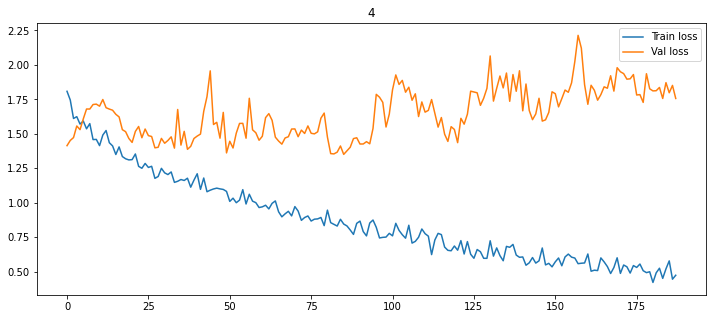

Final results Train:0.669 | Val:0.158 | Test: 0.125


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/350293 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/347090 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 22, 256, 1]               0
            Conv2d-2           [-1, 16, 256, 1]             368
       BatchNorm2d-3           [-1, 16, 256, 1]              32
        Expression-4           [-1, 16, 256, 1]               0
        Expression-5           [-1, 1, 16, 256]               0
           Dropout-6           [-1, 1, 16, 256]               0
            Conv2d-7           [-1, 4, 17, 225]             260
       BatchNorm2d-8           [-1, 4, 17, 225]               8
        Expression-9           [-1, 4, 17, 225]               0
        MaxPool2d-10             [-1, 4, 8, 56]               0
          Dropout-11             [-1, 4, 8, 56]               0
           Conv2d-12             [-1, 4, 9, 53]             516
      BatchNorm2d-13             [-1, 4, 9, 53]               8
       Expression-14             [-1, 4

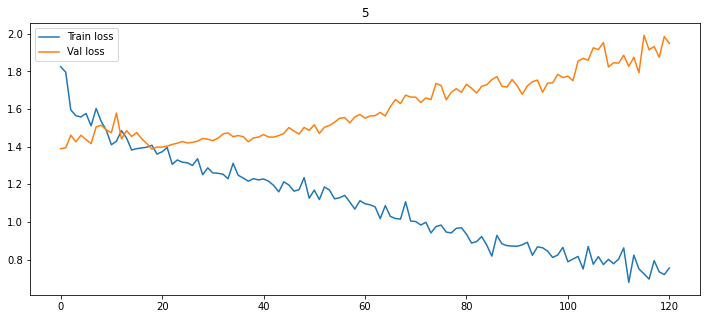

Final results Train:0.167 | Val:-0.036 | Test: 0.000


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/346638 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/340183 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 22, 256, 1]               0
            Conv2d-2           [-1, 16, 256, 1]             368
       BatchNorm2d-3           [-1, 16, 256, 1]              32
        Expression-4           [-1, 16, 256, 1]               0
        Expression-5           [-1, 1, 16, 256]               0
           Dropout-6           [-1, 1, 16, 256]               0
            Conv2d-7           [-1, 4, 17, 225]             260
       BatchNorm2d-8           [-1, 4, 17, 225]               8
        Expression-9           [-1, 4, 17, 225]               0
        MaxPool2d-10             [-1, 4, 8, 56]               0
          Dropout-11             [-1, 4, 8, 56]               0
           Conv2d-12             [-1, 4, 9, 53]             516
      BatchNorm2d-13             [-1, 4, 9, 53]               8
       Expression-14             [-1, 4

123-91/100) T:0.669 -> 0.716 | V:1.713 (Best: 1.376)
124-92/100) T:0.657 -> 0.672 | V:1.677 (Best: 1.376)
125-93/100) T:0.641 -> 0.681 | V:1.576 (Best: 1.376)
126-94/100) T:0.695 -> 0.644 | V:1.703 (Best: 1.376)
127-95/100) T:0.726 -> 0.605 | V:1.743 (Best: 1.376)
128-96/100) T:0.727 -> 0.643 | V:1.821 (Best: 1.376)
129-97/100) T:0.650 -> 0.587 | V:1.670 (Best: 1.376)
130-98/100) T:0.665 -> 0.665 | V:1.769 (Best: 1.376)
131-99/100) T:0.656 -> 0.563 | V:1.910 (Best: 1.376)
132-100/100) T:0.723 -> 0.622 | V:1.780 (Best: 1.376)
133-101/100) T:0.652 -> 0.611 | V:1.781 (Best: 1.376)


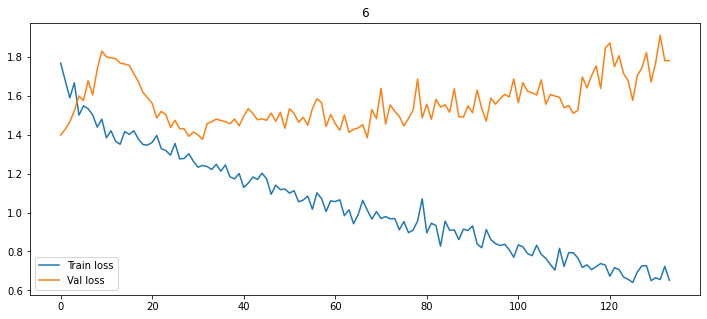

Final results Train:0.417 | Val:0.074 | Test: 0.083


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/347708 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/343645 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 22, 256, 1]               0
            Conv2d-2           [-1, 16, 256, 1]             368
       BatchNorm2d-3           [-1, 16, 256, 1]              32
        Expression-4           [-1, 16, 256, 1]               0
        Expression-5           [-1, 1, 16, 256]               0
           Dropout-6           [-1, 1, 16, 256]               0
            Conv2d-7           [-1, 4, 17, 225]             260
       BatchNorm2d-8           [-1, 4, 17, 225]               8
        Expression-9           [-1, 4, 17, 225]               0
        MaxPool2d-10             [-1, 4, 8, 56]               0
          Dropout-11             [-1, 4, 8, 56]               0
           Conv2d-12             [-1, 4, 9, 53]             516
      BatchNorm2d-13             [-1, 4, 9, 53]               8
       Expression-14             [-1, 4

123-11/100) T:0.459 -> 0.435 | V:1.783 (Best: 1.017)
124-12/100) T:0.565 -> 0.453 | V:1.278 (Best: 1.017)
125-13/100) T:0.480 -> 0.492 | V:0.999 (Best: 1.017)
126-0/100) T:0.442 -> 0.459 | V:1.204 (Best: 0.999)
127-1/100) T:0.431 -> 0.400 | V:1.309 (Best: 0.999)
128-2/100) T:0.465 -> 0.458 | V:1.329 (Best: 0.999)
129-3/100) T:0.420 -> 0.393 | V:1.255 (Best: 0.999)
130-4/100) T:0.494 -> 0.416 | V:1.608 (Best: 0.999)
131-5/100) T:0.388 -> 0.411 | V:1.294 (Best: 0.999)
132-6/100) T:0.438 -> 0.404 | V:1.274 (Best: 0.999)
133-7/100) T:0.436 -> 0.436 | V:1.164 (Best: 0.999)
134-8/100) T:0.488 -> 0.443 | V:0.971 (Best: 0.999)
135-0/100) T:0.427 -> 0.396 | V:1.404 (Best: 0.971)
136-1/100) T:0.420 -> 0.388 | V:1.302 (Best: 0.971)
137-2/100) T:0.390 -> 0.348 | V:1.019 (Best: 0.971)
138-3/100) T:0.421 -> 0.429 | V:1.413 (Best: 0.971)
139-4/100) T:0.412 -> 0.388 | V:1.202 (Best: 0.971)
140-5/100) T:0.406 -> 0.415 | V:1.045 (Best: 0.971)
141-6/100) T:0.443 -> 0.461 | V:1.012 (Best: 0.971)
142-7/100

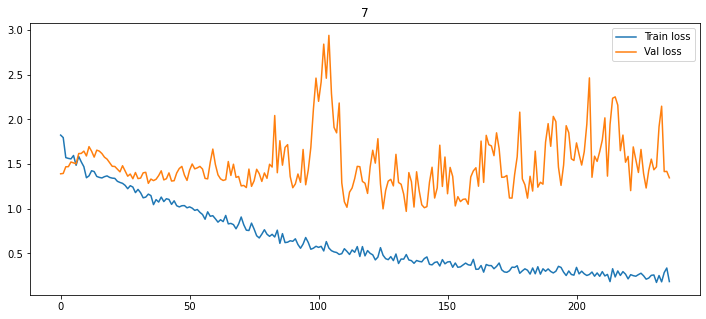

Final results Train:0.944 | Val:0.449 | Test: 0.329


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/344738 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/351150 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 22, 256, 1]               0
            Conv2d-2           [-1, 16, 256, 1]             368
       BatchNorm2d-3           [-1, 16, 256, 1]              32
        Expression-4           [-1, 16, 256, 1]               0
        Expression-5           [-1, 1, 16, 256]               0
           Dropout-6           [-1, 1, 16, 256]               0
            Conv2d-7           [-1, 4, 17, 225]             260
       BatchNorm2d-8           [-1, 4, 17, 225]               8
        Expression-9           [-1, 4, 17, 225]               0
        MaxPool2d-10             [-1, 4, 8, 56]               0
          Dropout-11             [-1, 4, 8, 56]               0
           Conv2d-12             [-1, 4, 9, 53]             516
      BatchNorm2d-13             [-1, 4, 9, 53]               8
       Expression-14             [-1, 4

124-21/100) T:0.260 -> 0.294 | V:0.735 (Best: 0.605)
125-22/100) T:0.310 -> 0.269 | V:0.684 (Best: 0.605)
126-23/100) T:0.358 -> 0.290 | V:0.901 (Best: 0.605)
127-24/100) T:0.287 -> 0.331 | V:0.810 (Best: 0.605)
128-25/100) T:0.299 -> 0.291 | V:0.820 (Best: 0.605)
129-26/100) T:0.295 -> 0.303 | V:0.669 (Best: 0.605)
130-27/100) T:0.291 -> 0.236 | V:0.800 (Best: 0.605)
131-28/100) T:0.304 -> 0.266 | V:0.992 (Best: 0.605)
132-29/100) T:0.321 -> 0.259 | V:0.947 (Best: 0.605)
133-30/100) T:0.313 -> 0.284 | V:0.901 (Best: 0.605)
134-31/100) T:0.291 -> 0.245 | V:0.800 (Best: 0.605)
135-32/100) T:0.285 -> 0.301 | V:1.008 (Best: 0.605)
136-33/100) T:0.258 -> 0.246 | V:0.917 (Best: 0.605)
137-34/100) T:0.279 -> 0.280 | V:0.722 (Best: 0.605)
138-35/100) T:0.305 -> 0.276 | V:0.819 (Best: 0.605)
139-36/100) T:0.264 -> 0.222 | V:0.816 (Best: 0.605)
140-37/100) T:0.200 -> 0.193 | V:0.751 (Best: 0.605)
141-38/100) T:0.311 -> 0.285 | V:0.796 (Best: 0.605)
142-39/100) T:0.328 -> 0.278 | V:0.771 (Best: 

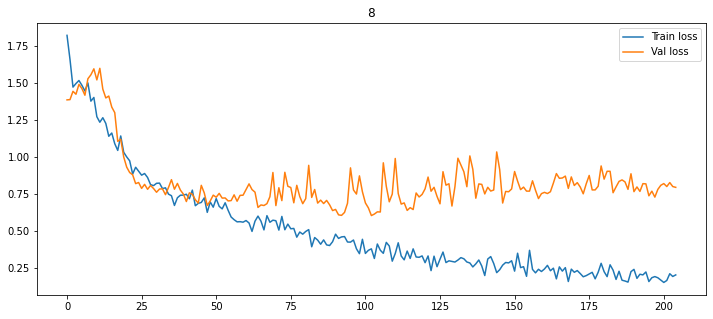

Final results Train:0.914 | Val:0.718 | Test: 0.634


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/343744 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/344650 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 22, 256, 1]               0
            Conv2d-2           [-1, 16, 256, 1]             368
       BatchNorm2d-3           [-1, 16, 256, 1]              32
        Expression-4           [-1, 16, 256, 1]               0
        Expression-5           [-1, 1, 16, 256]               0
           Dropout-6           [-1, 1, 16, 256]               0
            Conv2d-7           [-1, 4, 17, 225]             260
       BatchNorm2d-8           [-1, 4, 17, 225]               8
        Expression-9           [-1, 4, 17, 225]               0
        MaxPool2d-10             [-1, 4, 8, 56]               0
          Dropout-11             [-1, 4, 8, 56]               0
           Conv2d-12             [-1, 4, 9, 53]             516
      BatchNorm2d-13             [-1, 4, 9, 53]               8
       Expression-14             [-1, 4

124-7/100) T:0.217 -> 0.276 | V:0.698 (Best: 0.579)
125-8/100) T:0.255 -> 0.243 | V:0.625 (Best: 0.579)
126-9/100) T:0.278 -> 0.206 | V:0.635 (Best: 0.579)
127-10/100) T:0.227 -> 0.254 | V:0.727 (Best: 0.579)
128-11/100) T:0.190 -> 0.180 | V:0.617 (Best: 0.579)
129-12/100) T:0.220 -> 0.217 | V:0.611 (Best: 0.579)
130-13/100) T:0.313 -> 0.231 | V:0.601 (Best: 0.579)
131-14/100) T:0.192 -> 0.240 | V:0.617 (Best: 0.579)
132-15/100) T:0.189 -> 0.167 | V:0.587 (Best: 0.579)
133-16/100) T:0.199 -> 0.166 | V:0.572 (Best: 0.579)
134-0/100) T:0.203 -> 0.193 | V:0.640 (Best: 0.572)
135-1/100) T:0.223 -> 0.167 | V:0.665 (Best: 0.572)
136-2/100) T:0.267 -> 0.224 | V:0.580 (Best: 0.572)
137-3/100) T:0.271 -> 0.192 | V:0.582 (Best: 0.572)
138-4/100) T:0.187 -> 0.197 | V:0.652 (Best: 0.572)
139-5/100) T:0.230 -> 0.249 | V:0.690 (Best: 0.572)
140-6/100) T:0.231 -> 0.216 | V:0.604 (Best: 0.572)
141-7/100) T:0.258 -> 0.249 | V:0.630 (Best: 0.572)
142-8/100) T:0.165 -> 0.172 | V:0.599 (Best: 0.572)
143-9

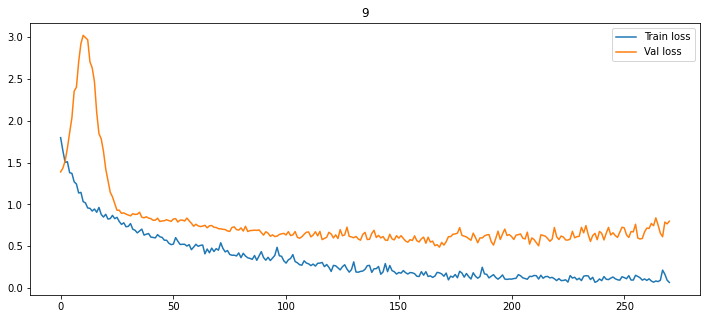

Final results Train:0.963 | Val:0.775 | Test: 0.537


In [266]:
import numpy as np
import mne
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch import nn
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ica_benchmark.processing.ica import get_ica_instance
from copy import deepcopy
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)
random_state = 1

mne.set_log_level(0)
bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')
# raw_fn = lambda raw: apply_raw(exponential_standardize, raw)
raw_fn = lambda raw: apply_raw(process_raw_fn, raw.copy().resample(128))

dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)

fold_sizes = None

splitter = Splitter(
    dataset,
    uids=dataset.list_uids(),
#     uids=["8"],
    sessions=dataset.SESSIONS,
    runs=dataset.RUNS,
    load_kwargs=dict(
        reject=False,
        tmin=0.5,
        tmax=2.6,
        raw_fn=raw_fn,
        concatenate=False
    ),
    splitter=KFold(4),
    intra_session_shuffle=False,
    fold_sizes=fold_sizes,
)

filter_kwargs = dict(
    method="fir",
#     iir_params=dict(
#         order=3,
#         ftype="butter"
#     )
)
splits_iterable = splitter.yield_splits_epochs(mode="inter_session")
results = list()
for i, fold_splits in enumerate(splits_iterable):
    
    uid = fold_splits[0]["uid"][0]
    
    train_epochs, test_epochs = splitter.load_from_splits(fold_splits, fold_sizes=None)
    if isinstance(train_epochs, (list, tuple)):
        train_epochs = train_epochs[0].load_data()
        test_epochs = test_epochs[0].load_data()
        
    n_channels = len(train_epochs.ch_names)

    train_data = train_epochs.copy().get_data()[..., :256]
    test_data = test_epochs.copy().get_data()[..., :256]
    train_labels = train_epochs.events[:, 2]
    test_labels = test_epochs.events[:, 2]
    
    del train_epochs, test_epochs


    train_data = np.expand_dims(train_data, axis=1)
    test_data = np.expand_dims(test_data, axis=1)
    
    train_data, train_labels = torch.from_numpy(train_data).float(), torch.from_numpy(train_labels).to(dtype=torch.int64)
    test_data, test_labels = torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).to(dtype=torch.int64)
    
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=.25, random_state=random_state)
    
    val_data = val_data.squeeze()
    train_data = train_data.squeeze()
    test_data = test_data.squeeze()
    
    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
    torch.manual_seed(random_state)
    model = EEGNetv1(n_channels, 4, input_window_samples=256).float()
    summary(model, input_size=(n_channels, 256), device="cpu")
    
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    best_state = None
    best_val_loss = 1000
    patience = 0
    max_patience = 100
    min_delta = 1e-3
    
    train_losses = list()
    val_losses = list()
    for epoch in range(1000):
        
        optim = Adam(model.parameters(), lr=1e-3)
        
        epoch_loss = 0
        epoch_loss_after_norm = 0
        model.train()
        for batch_number, (batch_x, batch_y) in enumerate(train_dataloader):
            optim.zero_grad()
            
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            epoch_loss += loss.item() / len(train_dataloader)

            loss.backward()
            optim.step()
            
            # Projection to norm constraints
#             model.apply_constraints()
            
            epoch_loss_after_norm += criterion(model(batch_x), batch_y).item() / len(train_dataloader)

        model.eval()
        val_loss = criterion(
            model(val_data),
            val_labels
        ).item()

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        
        print("{}-{}/{}) T:{:.3f} -> {:.3f} | V:{:.3f} (Best: {:.3f})".format(epoch, patience, max_patience, epoch_loss, epoch_loss_after_norm, val_loss, best_val_loss))
        
        if (best_val_loss - val_loss) > min_delta:
            best_state = deepcopy(model.state_dict())
            best_val_loss = val_loss
            patience = 0
        elif patience > max_patience:
            break
        else:
            patience += 1
    
    model.load_state_dict(best_state)
    model.eval()
    train_kappa = cohen_kappa_score(
        train_labels,
#         (model(train_data) > .5).detach().numpy().argmax(axis=1)
        model(train_data).detach().numpy().argmax(axis=1)
    )
    val_kappa = cohen_kappa_score(
        val_labels,
        model(val_data).detach().numpy().argmax(axis=1)
    )
    test_kappa = cohen_kappa_score(
        test_labels,
        model(test_data).detach().numpy().argmax(axis=1)
    )
    results.append(
        dict(
            uid=uid,
            train_kappa=train_kappa,
            val_kappa=val_kappa,
            test_kappa=test_kappa,
            
        )
    )
    plt.figure(figsize=(12, 5))
    plt.title(uid)
    plt.plot(range(len(train_losses)), train_losses, label="Train loss")
    plt.plot(range(len(val_losses)), val_losses, label="Val loss")
    plt.legend()
    plt.show()

    print("Final results Train:{:.3f} | Val:{:.3f} | Test: {:.3f}".format(train_kappa, val_kappa, test_kappa))

In [267]:
pd.DataFrame.from_records(results)

uid  train_kappa  val_kappa  test_kappa
0   1     0.919760   0.610209    0.578704
1   2     0.240719   0.155810    0.087963
2   3     0.882612   0.607273    0.578704
3   4     0.668580   0.158004    0.125000
4   5     0.166591  -0.036107    0.000000
5   6     0.417339   0.073836    0.083333
6   7     0.944438   0.449222    0.328704
7   8     0.913679   0.717647    0.634259
8   9     0.962904   0.774707    0.537037

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/343334 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/350744 [00:00<?, ?it/s]

SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/1000 [00:00<?, ?it/s]

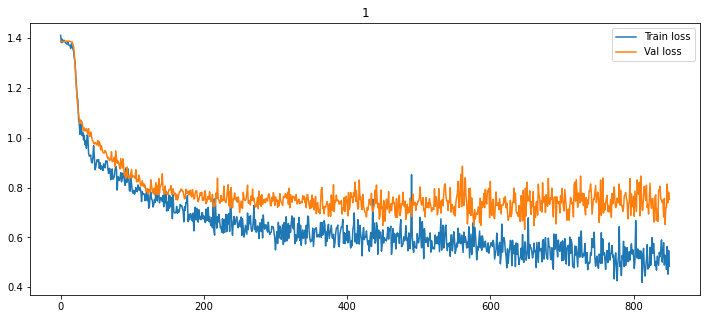

Final results:
{
    "uid": "1",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.8608379972772652,
    "val_cohen_kappa_score": 0.6544876886417792,
    "test_cohen_kappa_score": 0.6759259259259259,
    "train_balanced_accuracy_score": 0.895935960591133,
    "val_balanced_accuracy_score": 0.7388392857142858,
    "test_balanced_accuracy_score": 0.7569444444444444,
    "train_macro_f1": 0.89451437127532,
    "val_macro_f1": 0.7360010360010361,
    "test_macro_f1": 0.7554539509027631,
    "train_micro_f1": 0.8956521739130435,
    "val_micro_f1": 0.7413793103448276,
    "test_micro_f1": 0.7569444444444444
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             17

  0%|          | 0/1000 [00:00<?, ?it/s]

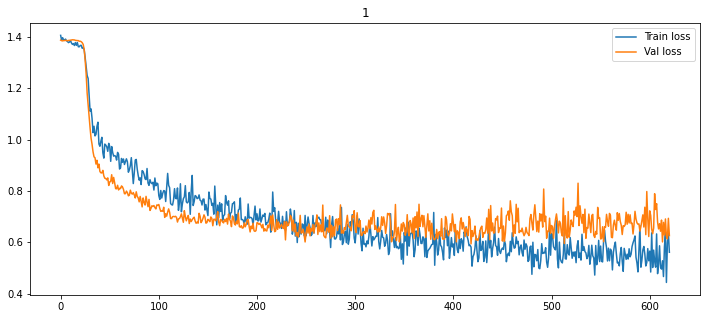

Final results:
{
    "uid": "1",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.8087583148558758,
    "val_cohen_kappa_score": 0.6286514605842337,
    "test_cohen_kappa_score": 0.6805555555555556,
    "train_balanced_accuracy_score": 0.8567291854842995,
    "val_balanced_accuracy_score": 0.7196186166774401,
    "test_balanced_accuracy_score": 0.7604166666666666,
    "train_macro_f1": 0.8527311169802188,
    "val_macro_f1": 0.7190170940170941,
    "test_macro_f1": 0.7591665914289154,
    "train_micro_f1": 0.8565217391304348,
    "val_micro_f1": 0.7241379310344829,
    "test_micro_f1": 0.7604166666666666
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

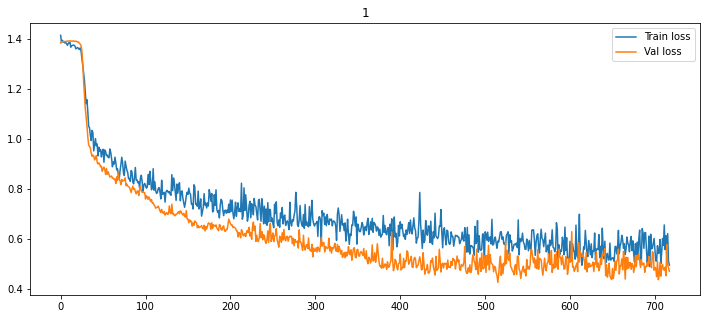

Final results:
{
    "uid": "1",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.8435689455388181,
    "val_cohen_kappa_score": 0.7921974522292994,
    "test_cohen_kappa_score": 0.6481481481481481,
    "train_balanced_accuracy_score": 0.8839577757954207,
    "val_balanced_accuracy_score": 0.8417043740573152,
    "test_balanced_accuracy_score": 0.736111111111111,
    "train_macro_f1": 0.8818353536602965,
    "val_macro_f1": 0.8414285714285713,
    "test_macro_f1": 0.7349004853211589,
    "train_micro_f1": 0.8826086956521739,
    "val_micro_f1": 0.8448275862068967,
    "test_micro_f1": 0.7361111111111113
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

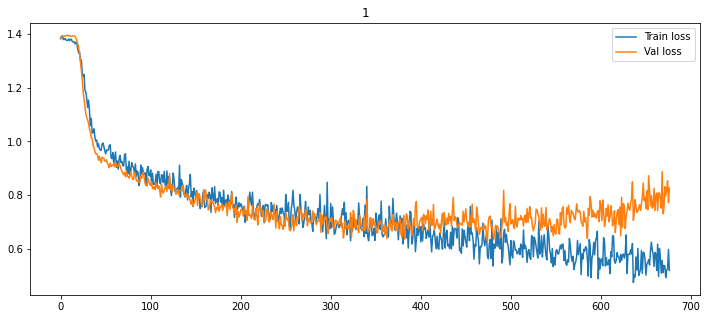

Final results:
{
    "uid": "1",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.8441529235382309,
    "val_cohen_kappa_score": 0.5526641883519208,
    "test_cohen_kappa_score": 0.712962962962963,
    "train_balanced_accuracy_score": 0.8847439916405434,
    "val_balanced_accuracy_score": 0.6495098039215685,
    "test_balanced_accuracy_score": 0.7847222222222223,
    "train_macro_f1": 0.883054578026115,
    "val_macro_f1": 0.6373256373256373,
    "test_macro_f1": 0.7831983910386708,
    "train_micro_f1": 0.8831168831168831,
    "val_micro_f1": 0.6666666666666666,
    "test_micro_f1": 0.7847222222222222
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             1

  0%|          | 0/1000 [00:00<?, ?it/s]

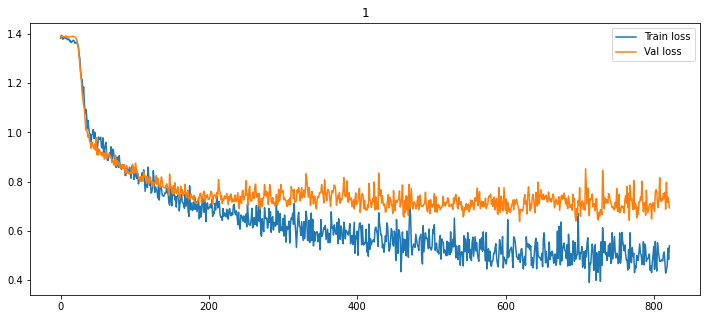

Final results:
{
    "uid": "1",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.8729214073166462,
    "val_cohen_kappa_score": 0.53125,
    "test_cohen_kappa_score": 0.6805555555555556,
    "train_balanced_accuracy_score": 0.902335157536794,
    "val_balanced_accuracy_score": 0.6629767291531997,
    "test_balanced_accuracy_score": 0.7604166666666667,
    "train_macro_f1": 0.9020220127013383,
    "val_macro_f1": 0.6587037037037037,
    "test_macro_f1": 0.7600791392158298,
    "train_micro_f1": 0.9047619047619048,
    "val_micro_f1": 0.6491228070175439,
    "test_micro_f1": 0.7604166666666666
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/345711 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/338285 [00:00<?, ?it/s]

SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/1000 [00:00<?, ?it/s]

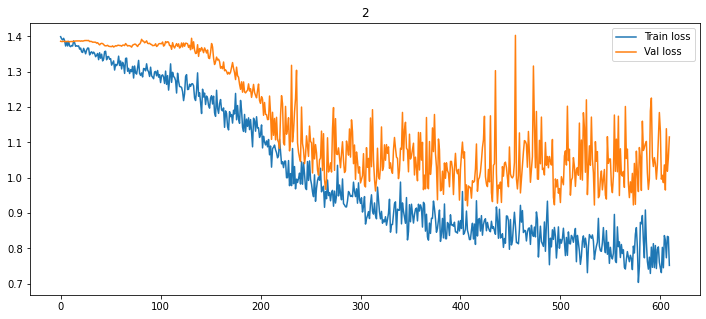

Final results:
{
    "uid": "2",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.7159491884262527,
    "val_cohen_kappa_score": 0.4248314161047203,
    "test_cohen_kappa_score": 0.2592592592592593,
    "train_balanced_accuracy_score": 0.7870538415003024,
    "val_balanced_accuracy_score": 0.5666666666666667,
    "test_balanced_accuracy_score": 0.4444444444444444,
    "train_macro_f1": 0.7859330376323704,
    "val_macro_f1": 0.5438814866760169,
    "test_macro_f1": 0.4361678416907994,
    "train_micro_f1": 0.7869565217391304,
    "val_micro_f1": 0.5689655172413793,
    "test_micro_f1": 0.4444444444444444
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

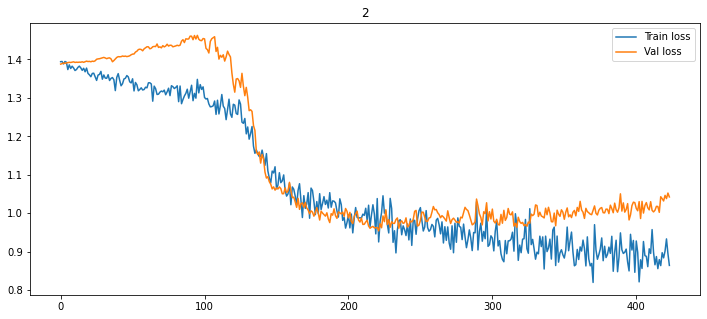

Final results:
{
    "uid": "2",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.5710036799919342,
    "val_cohen_kappa_score": 0.5135782747603834,
    "test_cohen_kappa_score": 0.2129629629629629,
    "train_balanced_accuracy_score": 0.6784304511278195,
    "val_balanced_accuracy_score": 0.6322916666666667,
    "test_balanced_accuracy_score": 0.4097222222222222,
    "train_macro_f1": 0.6741909120627656,
    "val_macro_f1": 0.6333333333333333,
    "test_macro_f1": 0.382493106616908,
    "train_micro_f1": 0.6782608695652174,
    "val_micro_f1": 0.6379310344827587,
    "test_micro_f1": 0.4097222222222222
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

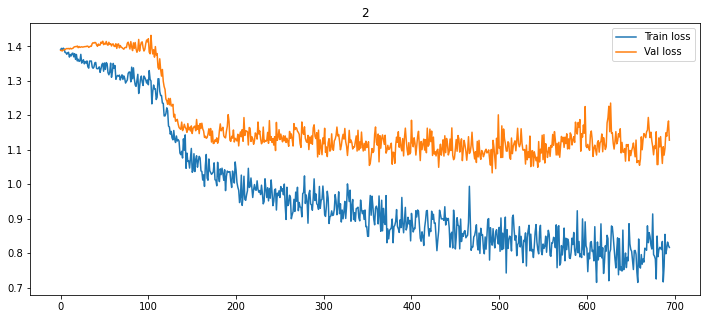

Final results:
{
    "uid": "2",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.6987026073812823,
    "val_cohen_kappa_score": 0.3130675088827477,
    "test_cohen_kappa_score": 0.32407407407407407,
    "train_balanced_accuracy_score": 0.7738636363636364,
    "val_balanced_accuracy_score": 0.49754901960784315,
    "test_balanced_accuracy_score": 0.4930555555555556,
    "train_macro_f1": 0.7699553435564913,
    "val_macro_f1": 0.4890902108644044,
    "test_macro_f1": 0.4707683215130023,
    "train_micro_f1": 0.7739130434782608,
    "val_micro_f1": 0.4827586206896552,
    "test_micro_f1": 0.4930555555555556
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]          

  0%|          | 0/1000 [00:00<?, ?it/s]

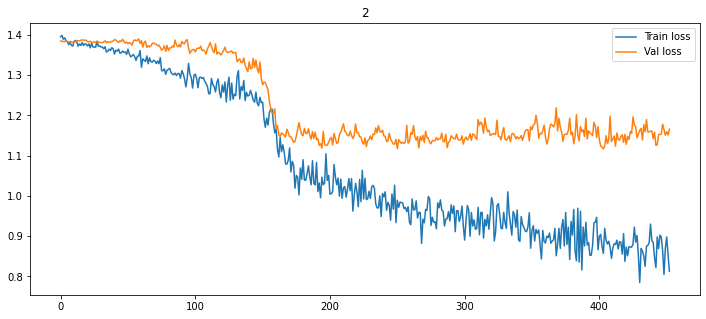

Final results:
{
    "uid": "2",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.5842935339548603,
    "val_cohen_kappa_score": 0.1823770491803277,
    "test_cohen_kappa_score": 0.29166666666666663,
    "train_balanced_accuracy_score": 0.6880801773308464,
    "val_balanced_accuracy_score": 0.38895173453996984,
    "test_balanced_accuracy_score": 0.46875,
    "train_macro_f1": 0.6771394065848937,
    "val_macro_f1": 0.37628284072249585,
    "test_macro_f1": 0.4534226923997288,
    "train_micro_f1": 0.6883116883116883,
    "val_micro_f1": 0.38596491228070173,
    "test_micro_f1": 0.46875
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchN

  0%|          | 0/1000 [00:00<?, ?it/s]

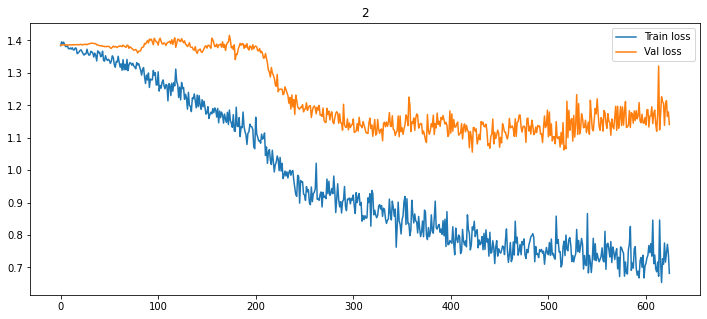

Final results:
{
    "uid": "2",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.798001249219238,
    "val_cohen_kappa_score": 0.39312039312039304,
    "test_cohen_kappa_score": 0.2314814814814815,
    "train_balanced_accuracy_score": 0.8490264234519672,
    "val_balanced_accuracy_score": 0.5441391941391942,
    "test_balanced_accuracy_score": 0.4236111111111111,
    "train_macro_f1": 0.8482588215409189,
    "val_macro_f1": 0.5408234537266796,
    "test_macro_f1": 0.3897094283223315,
    "train_micro_f1": 0.8484848484848486,
    "val_micro_f1": 0.543859649122807,
    "test_micro_f1": 0.4236111111111111
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/337191 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/331173 [00:00<?, ?it/s]

SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/1000 [00:00<?, ?it/s]

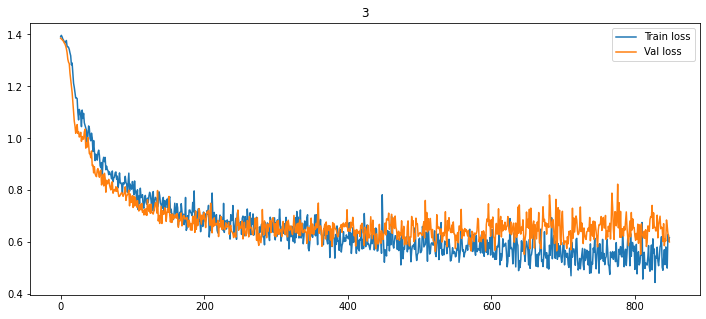

Final results:
{
    "uid": "3",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.8318416740199168,
    "val_cohen_kappa_score": 0.7244655581947743,
    "test_cohen_kappa_score": 0.7175925925925926,
    "train_balanced_accuracy_score": 0.8734119782214156,
    "val_balanced_accuracy_score": 0.7952380952380953,
    "test_balanced_accuracy_score": 0.7881944444444444,
    "train_macro_f1": 0.8689325899887397,
    "val_macro_f1": 0.7853695324283559,
    "test_macro_f1": 0.7816404898363664,
    "train_micro_f1": 0.8739130434782608,
    "val_micro_f1": 0.7931034482758621,
    "test_micro_f1": 0.7881944444444445
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

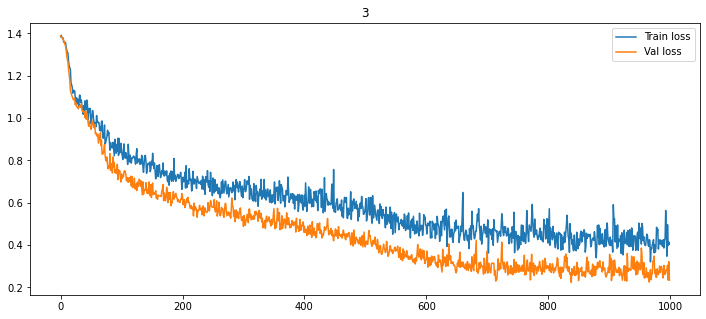

Final results:
{
    "uid": "3",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.9594182441458927,
    "val_cohen_kappa_score": 0.9538400318344608,
    "test_cohen_kappa_score": 0.8055555555555556,
    "train_balanced_accuracy_score": 0.9696585213032581,
    "val_balanced_accuracy_score": 0.9666666666666668,
    "test_balanced_accuracy_score": 0.8541666666666666,
    "train_macro_f1": 0.969484048680861,
    "val_macro_f1": 0.9671368861024034,
    "test_macro_f1": 0.8519435533410689,
    "train_micro_f1": 0.9695652173913043,
    "val_micro_f1": 0.9655172413793104,
    "test_micro_f1": 0.8541666666666666
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

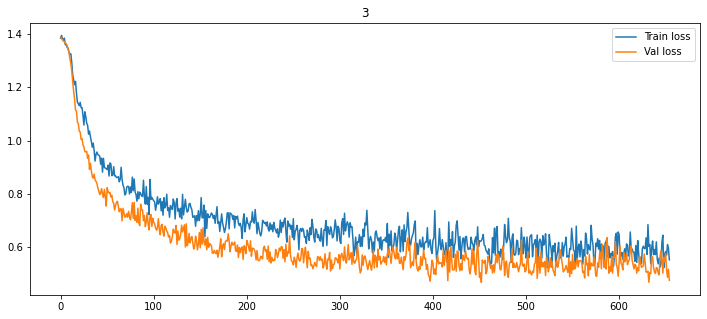

Final results:
{
    "uid": "3",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.7858311312444948,
    "val_cohen_kappa_score": 0.7910328262610088,
    "test_cohen_kappa_score": 0.6898148148148149,
    "train_balanced_accuracy_score": 0.8428030303030303,
    "val_balanced_accuracy_score": 0.8370098039215687,
    "test_balanced_accuracy_score": 0.7673611111111112,
    "train_macro_f1": 0.8312665893145188,
    "val_macro_f1": 0.8320007528703182,
    "test_macro_f1": 0.7464724276896605,
    "train_micro_f1": 0.8391304347826087,
    "val_micro_f1": 0.8448275862068967,
    "test_micro_f1": 0.7673611111111112
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

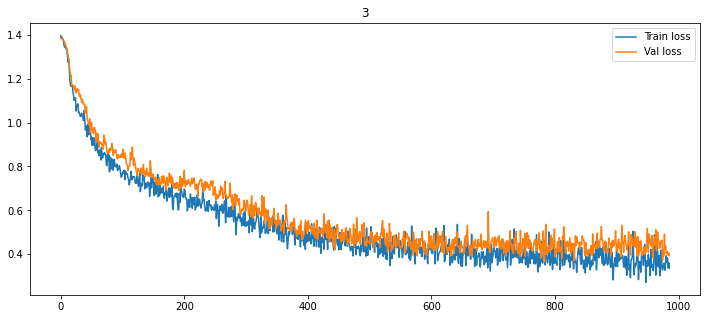

Final results:
{
    "uid": "3",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.9653569286142771,
    "val_cohen_kappa_score": 0.7648514851485149,
    "test_cohen_kappa_score": 0.8287037037037037,
    "train_balanced_accuracy_score": 0.9744201605709188,
    "val_balanced_accuracy_score": 0.824396681749623,
    "test_balanced_accuracy_score": 0.8715277777777778,
    "train_macro_f1": 0.9743026700016351,
    "val_macro_f1": 0.8183760683760684,
    "test_macro_f1": 0.8690549123043563,
    "train_micro_f1": 0.974025974025974,
    "val_micro_f1": 0.8245614035087719,
    "test_micro_f1": 0.8715277777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             1

  0%|          | 0/1000 [00:00<?, ?it/s]

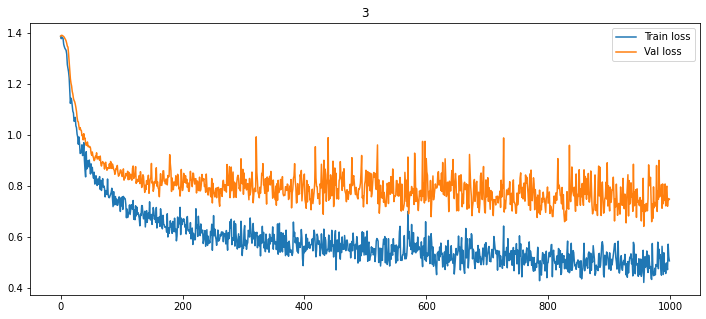

Final results:
{
    "uid": "3",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.87876440156949,
    "val_cohen_kappa_score": 0.5782983970406905,
    "test_cohen_kappa_score": 0.7037037037037037,
    "train_balanced_accuracy_score": 0.9084240774349668,
    "val_balanced_accuracy_score": 0.684981684981685,
    "test_balanced_accuracy_score": 0.7777777777777778,
    "train_macro_f1": 0.9059711610859247,
    "val_macro_f1": 0.6827808676307008,
    "test_macro_f1": 0.7610174938520009,
    "train_micro_f1": 0.9090909090909091,
    "val_micro_f1": 0.6842105263157895,
    "test_micro_f1": 0.7777777777777778
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/306668 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/336944 [00:00<?, ?it/s]

SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/1000 [00:00<?, ?it/s]

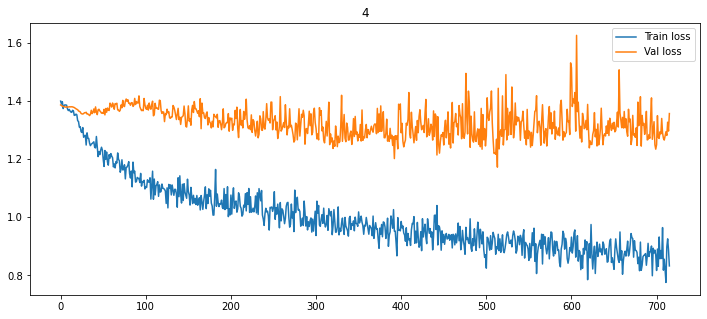

Final results:
{
    "uid": "4",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.6057772288458145,
    "val_cohen_kappa_score": 0.44674085850556444,
    "test_cohen_kappa_score": 0.4120370370370371,
    "train_balanced_accuracy_score": 0.7044767090139141,
    "val_balanced_accuracy_score": 0.5833333333333333,
    "test_balanced_accuracy_score": 0.5590277777777778,
    "train_macro_f1": 0.6981852360024982,
    "val_macro_f1": 0.5858998457682668,
    "test_macro_f1": 0.5491888897346765,
    "train_micro_f1": 0.7043478260869566,
    "val_micro_f1": 0.5862068965517241,
    "test_micro_f1": 0.5590277777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]           

  0%|          | 0/1000 [00:00<?, ?it/s]

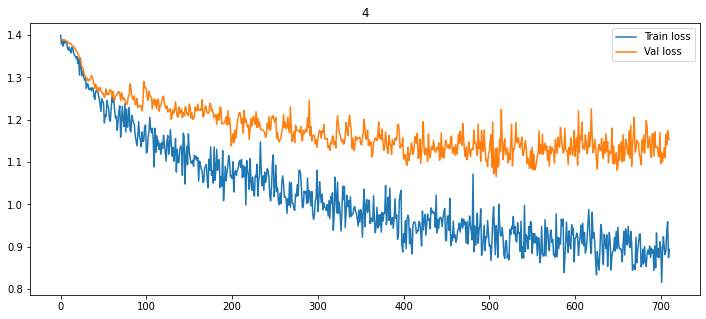

Final results:
{
    "uid": "4",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.6523141266282029,
    "val_cohen_kappa_score": 0.352988047808765,
    "test_cohen_kappa_score": 0.25462962962962965,
    "train_balanced_accuracy_score": 0.7391134085213033,
    "val_balanced_accuracy_score": 0.5125,
    "test_balanced_accuracy_score": 0.44097222222222227,
    "train_macro_f1": 0.7380250693760231,
    "val_macro_f1": 0.5105164949992537,
    "test_macro_f1": 0.4354053071610324,
    "train_micro_f1": 0.7391304347826085,
    "val_micro_f1": 0.5172413793103449,
    "test_micro_f1": 0.4409722222222222
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
      

  0%|          | 0/1000 [00:00<?, ?it/s]

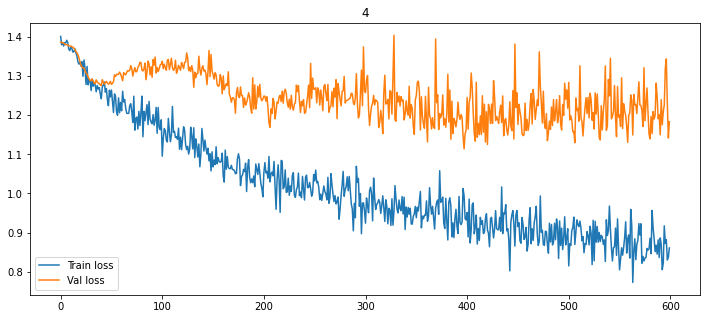

Final results:
{
    "uid": "4",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.6753377697116354,
    "val_cohen_kappa_score": 0.42460317460317465,
    "test_cohen_kappa_score": 0.39814814814814814,
    "train_balanced_accuracy_score": 0.7564674397859055,
    "val_balanced_accuracy_score": 0.5653846153846154,
    "test_balanced_accuracy_score": 0.5486111111111112,
    "train_macro_f1": 0.7566915625382978,
    "val_macro_f1": 0.5699300699300699,
    "test_macro_f1": 0.5424795024889422,
    "train_micro_f1": 0.7565217391304349,
    "val_micro_f1": 0.5689655172413793,
    "test_micro_f1": 0.5486111111111112
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]          

  0%|          | 0/1000 [00:00<?, ?it/s]

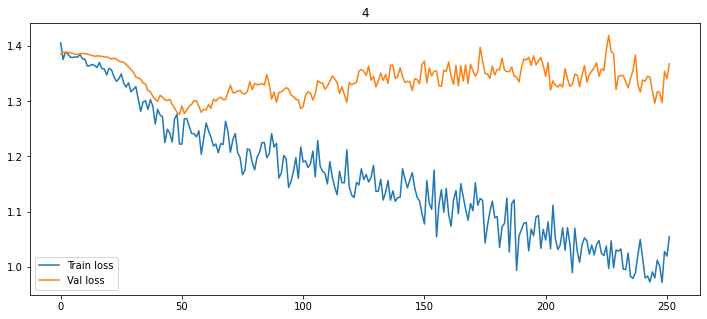

Final results:
{
    "uid": "4",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.3399007369529252,
    "val_cohen_kappa_score": 0.14718964820056601,
    "test_cohen_kappa_score": 0.2407407407407407,
    "train_balanced_accuracy_score": 0.5013535412571064,
    "val_balanced_accuracy_score": 0.36320297349709113,
    "test_balanced_accuracy_score": 0.4305555555555556,
    "train_macro_f1": 0.46346341940532076,
    "val_macro_f1": 0.332107555125458,
    "test_macro_f1": 0.37483840985657113,
    "train_micro_f1": 0.5064935064935064,
    "val_micro_f1": 0.3508771929824561,
    "test_micro_f1": 0.4305555555555556
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]         

  0%|          | 0/1000 [00:00<?, ?it/s]

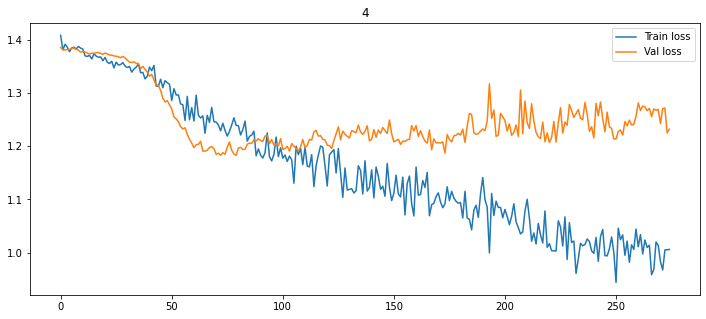

Final results:
{
    "uid": "4",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.2994210090984285,
    "val_cohen_kappa_score": 0.23598700243704307,
    "test_cohen_kappa_score": 0.19444444444444442,
    "train_balanced_accuracy_score": 0.47232455957251396,
    "val_balanced_accuracy_score": 0.4356112637362638,
    "test_balanced_accuracy_score": 0.39583333333333337,
    "train_macro_f1": 0.44380952380952376,
    "val_macro_f1": 0.3682163922479561,
    "test_macro_f1": 0.34743870229635965,
    "train_micro_f1": 0.47619047619047616,
    "val_micro_f1": 0.42105263157894735,
    "test_micro_f1": 0.3958333333333333
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/350293 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/347090 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

  0%|          | 0/1000 [00:00<?, ?it/s]

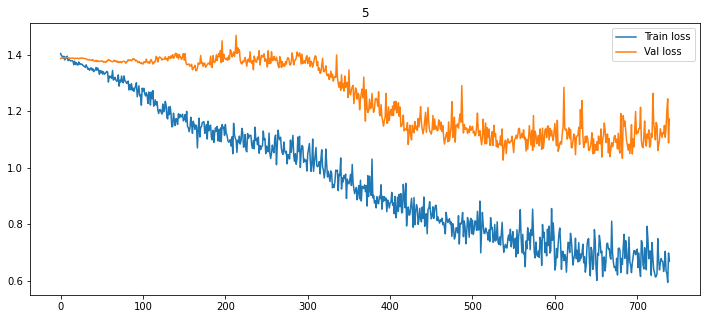

Final results:
{
    "uid": "5",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.7970400625267882,
    "val_cohen_kappa_score": 0.4041880679573292,
    "test_cohen_kappa_score": 0.3564814814814815,
    "train_balanced_accuracy_score": 0.8475499092558982,
    "val_balanced_accuracy_score": 0.5535714285714285,
    "test_balanced_accuracy_score": 0.517361111111111,
    "train_macro_f1": 0.8431619298108567,
    "val_macro_f1": 0.5553149177291054,
    "test_macro_f1": 0.4871071630035422,
    "train_micro_f1": 0.8478260869565218,
    "val_micro_f1": 0.5517241379310345,
    "test_micro_f1": 0.5173611111111112
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

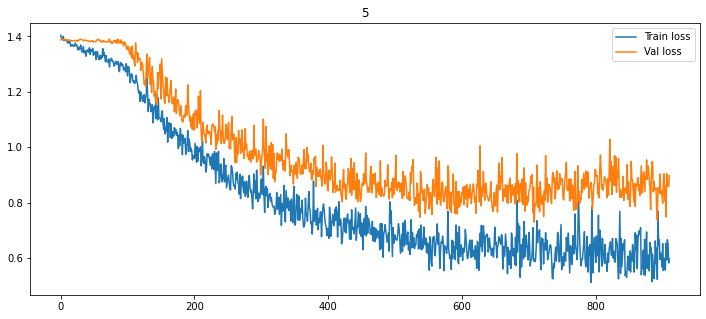

Final results:
{
    "uid": "5",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.8782117552131925,
    "val_cohen_kappa_score": 0.5387673956262427,
    "test_cohen_kappa_score": 0.3564814814814815,
    "train_balanced_accuracy_score": 0.9080200501253133,
    "val_balanced_accuracy_score": 0.6677083333333333,
    "test_balanced_accuracy_score": 0.517361111111111,
    "train_macro_f1": 0.9078087439425437,
    "val_macro_f1": 0.6374949219776807,
    "test_macro_f1": 0.46539854838362305,
    "train_micro_f1": 0.908695652173913,
    "val_micro_f1": 0.6551724137931034,
    "test_micro_f1": 0.5173611111111112
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

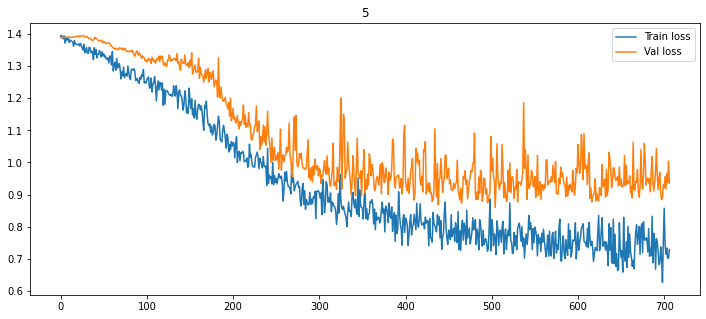

Final results:
{
    "uid": "5",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.7050911376492772,
    "val_cohen_kappa_score": 0.4172025723472669,
    "test_cohen_kappa_score": 0.2870370370370371,
    "train_balanced_accuracy_score": 0.7840909090909091,
    "val_balanced_accuracy_score": 0.5465686274509803,
    "test_balanced_accuracy_score": 0.46527777777777773,
    "train_macro_f1": 0.7737407301099065,
    "val_macro_f1": 0.5301120448179273,
    "test_macro_f1": 0.4225416829089815,
    "train_micro_f1": 0.7782608695652173,
    "val_micro_f1": 0.5689655172413793,
    "test_micro_f1": 0.4652777777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]           

  0%|          | 0/1000 [00:00<?, ?it/s]

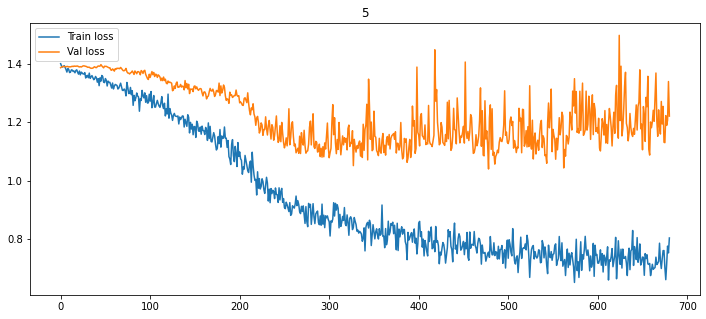

Final results:
{
    "uid": "5",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.7460079466226854,
    "val_cohen_kappa_score": 0.34158415841584155,
    "test_cohen_kappa_score": 0.2870370370370371,
    "train_balanced_accuracy_score": 0.8094497607655502,
    "val_balanced_accuracy_score": 0.5089555052790347,
    "test_balanced_accuracy_score": 0.4652777777777778,
    "train_macro_f1": 0.801268490718835,
    "val_macro_f1": 0.4898204736440031,
    "test_macro_f1": 0.45045598968287337,
    "train_micro_f1": 0.8095238095238095,
    "val_micro_f1": 0.5087719298245614,
    "test_micro_f1": 0.4652777777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]           

  0%|          | 0/1000 [00:00<?, ?it/s]

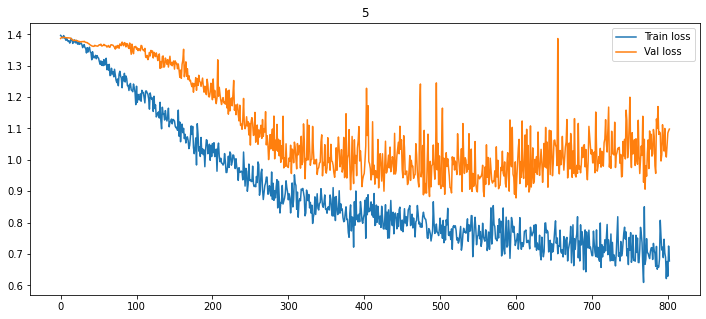

Final results:
{
    "uid": "5",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.7808568004793289,
    "val_cohen_kappa_score": 0.48331273176761436,
    "test_cohen_kappa_score": 0.3472222222222222,
    "train_balanced_accuracy_score": 0.837209183098014,
    "val_balanced_accuracy_score": 0.6056776556776557,
    "test_balanced_accuracy_score": 0.5104166666666667,
    "train_macro_f1": 0.8318271195220822,
    "val_macro_f1": 0.5936681124062528,
    "test_macro_f1": 0.4890797962947996,
    "train_micro_f1": 0.8354978354978355,
    "val_micro_f1": 0.6140350877192983,
    "test_micro_f1": 0.5104166666666666
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/346638 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/340183 [00:00<?, ?it/s]

SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/1000 [00:00<?, ?it/s]

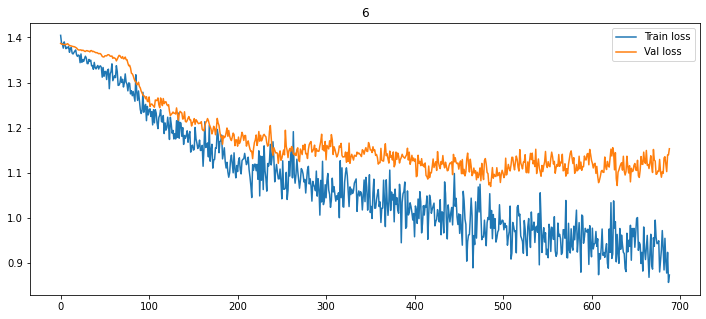

Final results:
{
    "uid": "6",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.6292098037733949,
    "val_cohen_kappa_score": 0.44297719087635057,
    "test_cohen_kappa_score": 0.2962962962962963,
    "train_balanced_accuracy_score": 0.7232718705003304,
    "val_balanced_accuracy_score": 0.5695169413919414,
    "test_balanced_accuracy_score": 0.4722222222222222,
    "train_macro_f1": 0.7177365317609219,
    "val_macro_f1": 0.5423533257696673,
    "test_macro_f1": 0.4615315941059246,
    "train_micro_f1": 0.7217391304347827,
    "val_micro_f1": 0.5862068965517241,
    "test_micro_f1": 0.4722222222222222
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]           

  0%|          | 0/1000 [00:00<?, ?it/s]

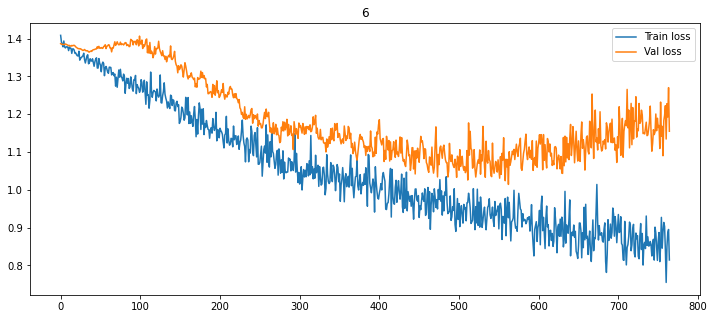

Final results:
{
    "uid": "6",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.6815687459094799,
    "val_cohen_kappa_score": 0.3977635782747604,
    "test_cohen_kappa_score": 0.32407407407407407,
    "train_balanced_accuracy_score": 0.7640625859319145,
    "val_balanced_accuracy_score": 0.542296918767507,
    "test_balanced_accuracy_score": 0.49305555555555547,
    "train_macro_f1": 0.7525357085540041,
    "val_macro_f1": 0.5375664867497898,
    "test_macro_f1": 0.4779769867813346,
    "train_micro_f1": 0.7608695652173914,
    "val_micro_f1": 0.5517241379310345,
    "test_micro_f1": 0.4930555555555556
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]           

  0%|          | 0/1000 [00:00<?, ?it/s]

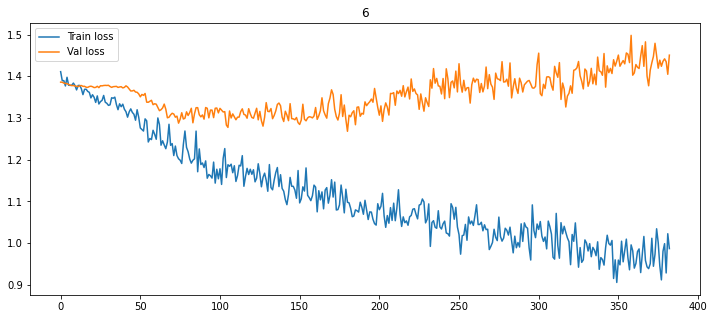

Final results:
{
    "uid": "6",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.4784054830418787,
    "val_cohen_kappa_score": 0.16043425814234014,
    "test_cohen_kappa_score": 0.20833333333333337,
    "train_balanced_accuracy_score": 0.6114903036279222,
    "val_balanced_accuracy_score": 0.356060606060606,
    "test_balanced_accuracy_score": 0.40625,
    "train_macro_f1": 0.6037181230173443,
    "val_macro_f1": 0.347872861433982,
    "test_macro_f1": 0.38727117395086824,
    "train_micro_f1": 0.6086956521739131,
    "val_micro_f1": 0.3793103448275862,
    "test_micro_f1": 0.40625
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm

  0%|          | 0/1000 [00:00<?, ?it/s]

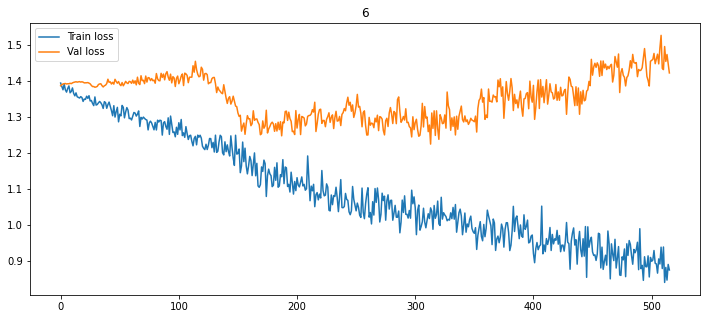

Final results:
{
    "uid": "6",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.5958813385649664,
    "val_cohen_kappa_score": 0.24659231722428743,
    "test_cohen_kappa_score": 0.24537037037037035,
    "train_balanced_accuracy_score": 0.6951330960097764,
    "val_balanced_accuracy_score": 0.44497414350355524,
    "test_balanced_accuracy_score": 0.4340277777777778,
    "train_macro_f1": 0.6994010390052801,
    "val_macro_f1": 0.4391000891000891,
    "test_macro_f1": 0.43446195843606905,
    "train_micro_f1": 0.696969696969697,
    "val_micro_f1": 0.43859649122807015,
    "test_micro_f1": 0.4340277777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]        

  0%|          | 0/1000 [00:00<?, ?it/s]

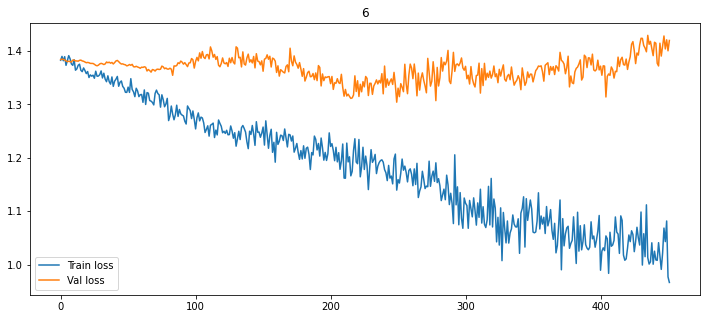

Final results:
{
    "uid": "6",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.49187621856721486,
    "val_cohen_kappa_score": 0.12598425196850382,
    "test_cohen_kappa_score": 0.14814814814814814,
    "train_balanced_accuracy_score": 0.6203868019765156,
    "val_balanced_accuracy_score": 0.3265998707175177,
    "test_balanced_accuracy_score": 0.3611111111111111,
    "train_macro_f1": 0.6174250506774779,
    "val_macro_f1": 0.32492202729044833,
    "test_macro_f1": 0.3447119281253982,
    "train_micro_f1": 0.6190476190476191,
    "val_micro_f1": 0.3508771929824561,
    "test_micro_f1": 0.3611111111111111
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/347708 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/343645 [00:00<?, ?it/s]

SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/1000 [00:00<?, ?it/s]

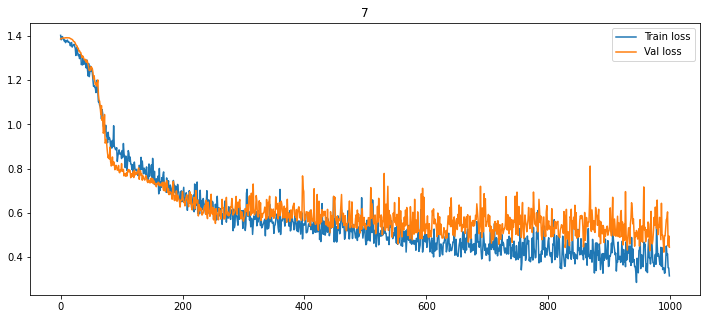

Final results:
{
    "uid": "7",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.9594202898550724,
    "val_cohen_kappa_score": 0.7231503579952268,
    "test_cohen_kappa_score": 0.6481481481481481,
    "train_balanced_accuracy_score": 0.9696007259528131,
    "val_balanced_accuracy_score": 0.7880952380952382,
    "test_balanced_accuracy_score": 0.7361111111111112,
    "train_macro_f1": 0.9695632446934428,
    "val_macro_f1": 0.7871074879227054,
    "test_macro_f1": 0.7199833499833499,
    "train_micro_f1": 0.9695652173913043,
    "val_micro_f1": 0.7931034482758621,
    "test_micro_f1": 0.7361111111111113
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

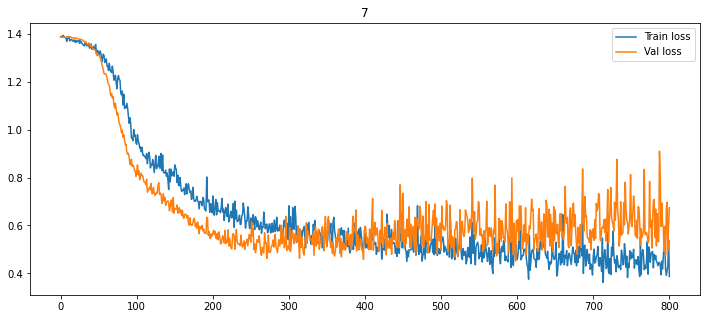

Final results:
{
    "uid": "7",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.8030375538372415,
    "val_cohen_kappa_score": 0.5832335329341317,
    "test_cohen_kappa_score": 0.587962962962963,
    "train_balanced_accuracy_score": 0.8539160401002506,
    "val_balanced_accuracy_score": 0.6697916666666667,
    "test_balanced_accuracy_score": 0.6909722222222222,
    "train_macro_f1": 0.851704466279201,
    "val_macro_f1": 0.6714658904314077,
    "test_macro_f1": 0.6842258543396383,
    "train_micro_f1": 0.8521739130434782,
    "val_micro_f1": 0.6896551724137931,
    "test_micro_f1": 0.6909722222222222
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             1

  0%|          | 0/1000 [00:00<?, ?it/s]

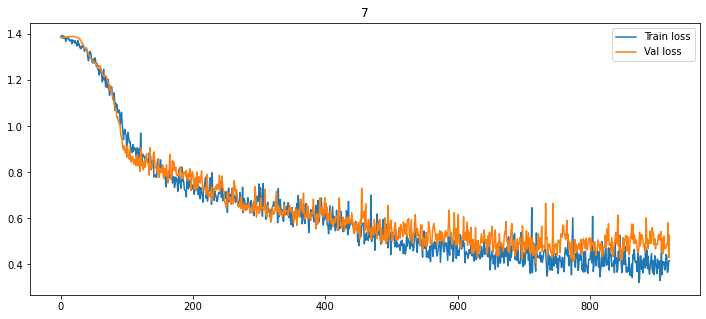

Final results:
{
    "uid": "7",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.9246376811594202,
    "val_cohen_kappa_score": 0.8142514011208968,
    "test_cohen_kappa_score": 0.587962962962963,
    "train_balanced_accuracy_score": 0.9443181818181818,
    "val_balanced_accuracy_score": 0.857843137254902,
    "test_balanced_accuracy_score": 0.6909722222222222,
    "train_macro_f1": 0.9434624478766678,
    "val_macro_f1": 0.8563372859025032,
    "test_macro_f1": 0.6803862076482913,
    "train_micro_f1": 0.9434782608695652,
    "val_micro_f1": 0.8620689655172413,
    "test_micro_f1": 0.6909722222222222
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             1

  0%|          | 0/1000 [00:00<?, ?it/s]

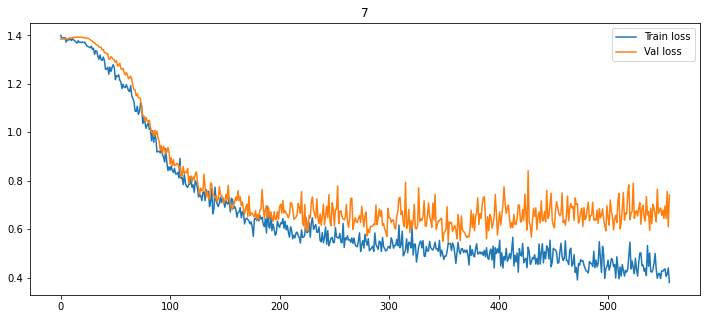

Final results:
{
    "uid": "7",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.8382919145957298,
    "val_cohen_kappa_score": 0.7426108374384237,
    "test_cohen_kappa_score": 0.5,
    "train_balanced_accuracy_score": 0.8769635471575703,
    "val_balanced_accuracy_score": 0.813367269984917,
    "test_balanced_accuracy_score": 0.625,
    "train_macro_f1": 0.8770955165692008,
    "val_macro_f1": 0.8064990140560219,
    "test_macro_f1": 0.5841858574685097,
    "train_micro_f1": 0.8787878787878788,
    "val_micro_f1": 0.8070175438596491,
    "test_micro_f1": 0.625
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 

  0%|          | 0/1000 [00:00<?, ?it/s]

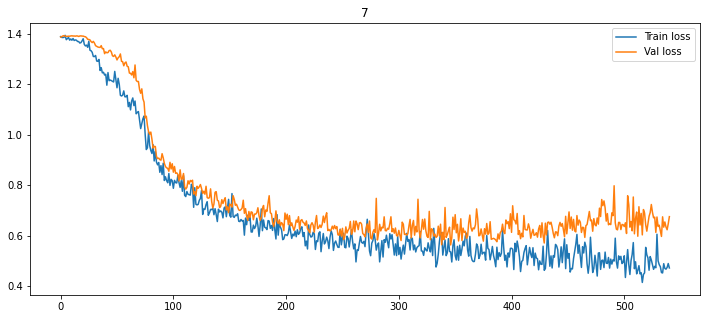

Final results:
{
    "uid": "7",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.821033164221628,
    "val_cohen_kappa_score": 0.5789905621665983,
    "test_cohen_kappa_score": 0.45833333333333337,
    "train_balanced_accuracy_score": 0.8660460692936316,
    "val_balanced_accuracy_score": 0.6808608058608059,
    "test_balanced_accuracy_score": 0.59375,
    "train_macro_f1": 0.8663601225351776,
    "val_macro_f1": 0.6841140361718782,
    "test_macro_f1": 0.5694366626488657,
    "train_micro_f1": 0.8658008658008658,
    "val_micro_f1": 0.6842105263157895,
    "test_micro_f1": 0.59375
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/344738 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/351150 [00:00<?, ?it/s]

SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/1000 [00:00<?, ?it/s]

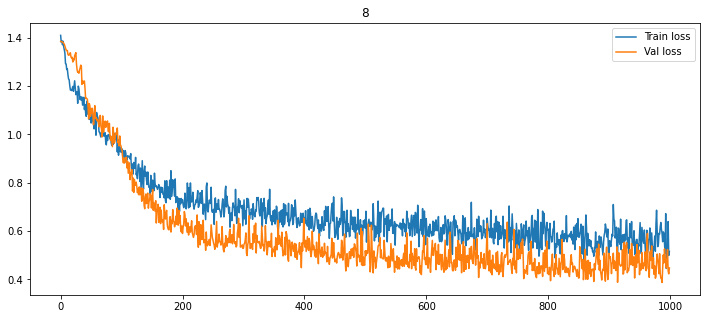

Final results:
{
    "uid": "8",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.8840228928724504,
    "val_cohen_kappa_score": 0.8391442155309033,
    "test_cohen_kappa_score": 0.6203703703703703,
    "train_balanced_accuracy_score": 0.9123563218390804,
    "val_balanced_accuracy_score": 0.8809523809523809,
    "test_balanced_accuracy_score": 0.7152777777777778,
    "train_macro_f1": 0.9095931144145246,
    "val_macro_f1": 0.8747113661428177,
    "test_macro_f1": 0.714401315151108,
    "train_micro_f1": 0.9130434782608695,
    "val_micro_f1": 0.8793103448275863,
    "test_micro_f1": 0.7152777777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

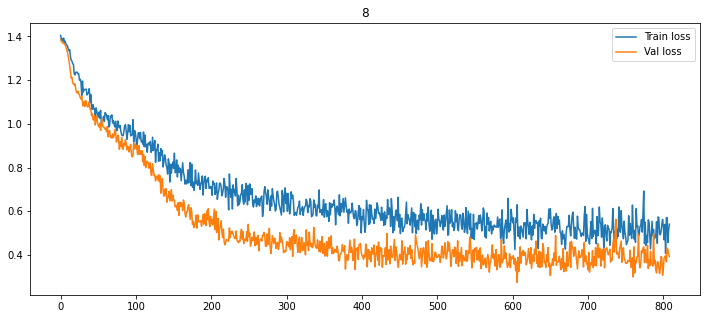

Final results:
{
    "uid": "8",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.9188323964608909,
    "val_cohen_kappa_score": 0.9079730265767553,
    "test_cohen_kappa_score": 0.6759259259259259,
    "train_balanced_accuracy_score": 0.9390977443609022,
    "val_balanced_accuracy_score": 0.934375,
    "test_balanced_accuracy_score": 0.7569444444444444,
    "train_macro_f1": 0.93868262407938,
    "val_macro_f1": 0.9293019368624207,
    "test_macro_f1": 0.7564211447181549,
    "train_micro_f1": 0.9391304347826087,
    "val_micro_f1": 0.9310344827586207,
    "test_micro_f1": 0.7569444444444444
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       

  0%|          | 0/1000 [00:00<?, ?it/s]

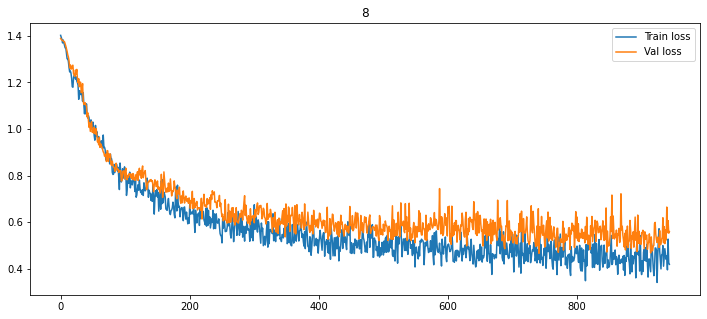

Final results:
{
    "uid": "8",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.9420070600100857,
    "val_cohen_kappa_score": 0.7922801432550737,
    "test_cohen_kappa_score": 0.6990740740740741,
    "train_balanced_accuracy_score": 0.9571969696969698,
    "val_balanced_accuracy_score": 0.8492647058823529,
    "test_balanced_accuracy_score": 0.7743055555555556,
    "train_macro_f1": 0.9568808096720269,
    "val_macro_f1": 0.8424347643097643,
    "test_macro_f1": 0.7761768618144145,
    "train_micro_f1": 0.9565217391304348,
    "val_micro_f1": 0.8448275862068967,
    "test_micro_f1": 0.7743055555555556
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

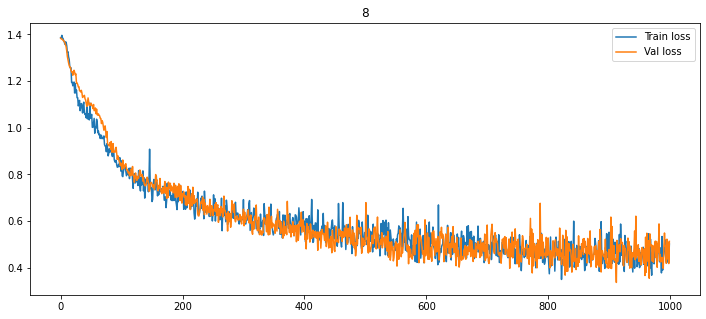

Final results:
{
    "uid": "8",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.9538161643424802,
    "val_cohen_kappa_score": 0.8590852904820767,
    "test_cohen_kappa_score": 0.6944444444444444,
    "train_balanced_accuracy_score": 0.9658675289919714,
    "val_balanced_accuracy_score": 0.8942684766214178,
    "test_balanced_accuracy_score": 0.7708333333333333,
    "train_macro_f1": 0.965567474721286,
    "val_macro_f1": 0.8917151883491294,
    "test_macro_f1": 0.7659309312274365,
    "train_micro_f1": 0.9653679653679653,
    "val_micro_f1": 0.8947368421052632,
    "test_micro_f1": 0.7708333333333333
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

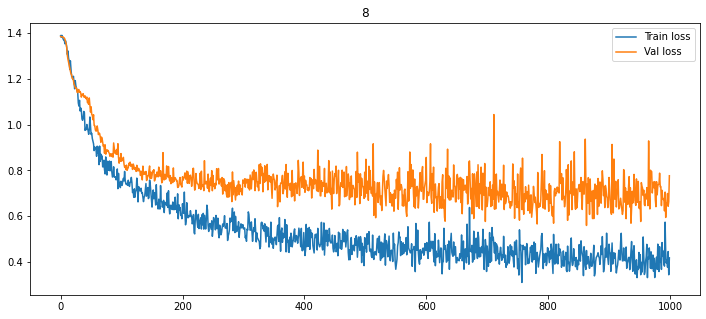

Final results:
{
    "uid": "8",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.9364861149298873,
    "val_cohen_kappa_score": 0.6717400246812012,
    "test_cohen_kappa_score": 0.6898148148148149,
    "train_balanced_accuracy_score": 0.9521299229956832,
    "val_balanced_accuracy_score": 0.7516483516483516,
    "test_balanced_accuracy_score": 0.7673611111111112,
    "train_macro_f1": 0.9525603917407037,
    "val_macro_f1": 0.7497201904098456,
    "test_macro_f1": 0.7647149384437519,
    "train_micro_f1": 0.9523809523809523,
    "val_micro_f1": 0.7543859649122807,
    "test_micro_f1": 0.7673611111111112
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/343744 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/344650 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

  0%|          | 0/1000 [00:00<?, ?it/s]

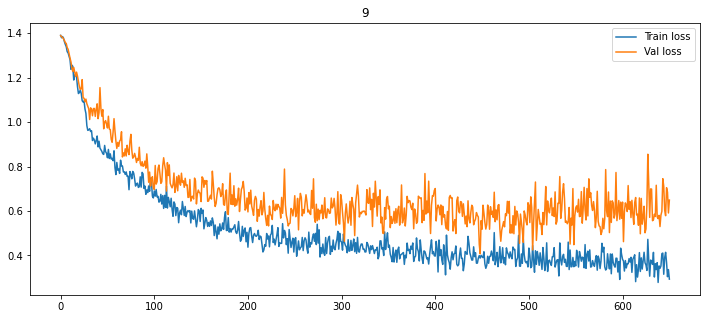

Final results:
{
    "uid": "9",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.9130478614814628,
    "val_cohen_kappa_score": 0.8388249305279873,
    "test_cohen_kappa_score": 0.6759259259259259,
    "train_balanced_accuracy_score": 0.9352615173234079,
    "val_balanced_accuracy_score": 0.8782394688644688,
    "test_balanced_accuracy_score": 0.7569444444444444,
    "train_macro_f1": 0.9350225345885905,
    "val_macro_f1": 0.8788211676316515,
    "test_macro_f1": 0.7373740802825197,
    "train_micro_f1": 0.9347826086956522,
    "val_micro_f1": 0.8793103448275863,
    "test_micro_f1": 0.7569444444444444
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

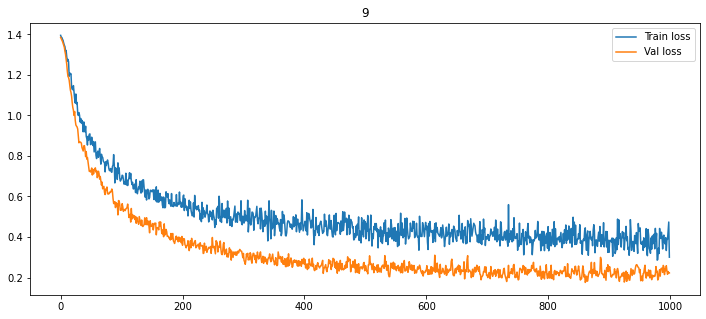

Final results:
{
    "uid": "9",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.9420026729202915,
    "val_cohen_kappa_score": 0.930622009569378,
    "test_cohen_kappa_score": 0.8101851851851851,
    "train_balanced_accuracy_score": 0.9565548864323818,
    "val_balanced_accuracy_score": 0.9436274509803921,
    "test_balanced_accuracy_score": 0.8576388888888888,
    "train_macro_f1": 0.9567222072315165,
    "val_macro_f1": 0.9449657869012708,
    "test_macro_f1": 0.8546949679378524,
    "train_micro_f1": 0.9565217391304348,
    "val_micro_f1": 0.9482758620689655,
    "test_micro_f1": 0.8576388888888888
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

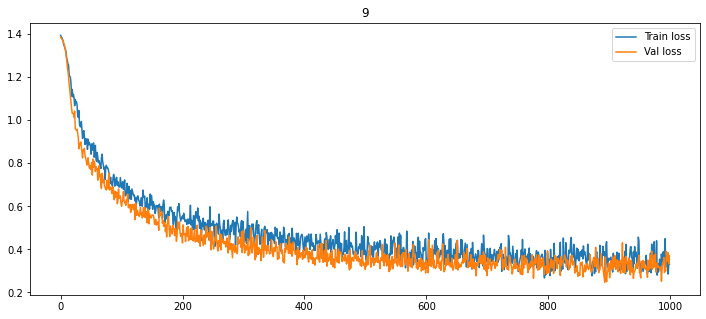

Final results:
{
    "uid": "9",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.9362158073868649,
    "val_cohen_kappa_score": 0.9304,
    "test_cohen_kappa_score": 0.7546296296296297,
    "train_balanced_accuracy_score": 0.9525131989810591,
    "val_balanced_accuracy_score": 0.9449810606060607,
    "test_balanced_accuracy_score": 0.8159722222222221,
    "train_macro_f1": 0.9523126835626834,
    "val_macro_f1": 0.9491715181370354,
    "test_macro_f1": 0.8136912502587734,
    "train_micro_f1": 0.9521739130434783,
    "val_micro_f1": 0.9482758620689655,
    "test_micro_f1": 0.8159722222222222
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       

  0%|          | 0/1000 [00:00<?, ?it/s]

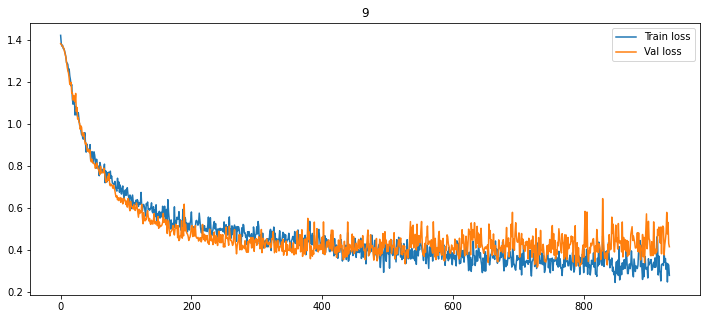

Final results:
{
    "uid": "9",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.9134074721979257,
    "val_cohen_kappa_score": 0.8824257425742574,
    "test_cohen_kappa_score": 0.7685185185185185,
    "train_balanced_accuracy_score": 0.9354750013283035,
    "val_balanced_accuracy_score": 0.9111182934712346,
    "test_balanced_accuracy_score": 0.8263888888888888,
    "train_macro_f1": 0.9346777846893219,
    "val_macro_f1": 0.9116198616198616,
    "test_macro_f1": 0.8282316640003182,
    "train_micro_f1": 0.935064935064935,
    "val_micro_f1": 0.9122807017543859,
    "test_micro_f1": 0.8263888888888888
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

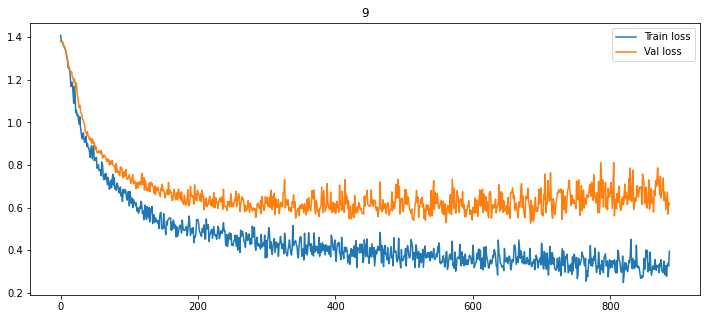

Final results:
{
    "uid": "9",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.9538207806487081,
    "val_cohen_kappa_score": 0.7417627677100495,
    "test_cohen_kappa_score": 0.7361111111111112,
    "train_balanced_accuracy_score": 0.9657935285053929,
    "val_balanced_accuracy_score": 0.8124595992243052,
    "test_balanced_accuracy_score": 0.8020833333333333,
    "train_macro_f1": 0.9654571362967164,
    "val_macro_f1": 0.8105218855218854,
    "test_macro_f1": 0.8045607850263152,
    "train_micro_f1": 0.9653679653679653,
    "val_micro_f1": 0.8070175438596491,
    "test_micro_f1": 0.8020833333333334
}


In [35]:
import numpy as np
import mne
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch import nn
from torchsummary import summary
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from ica_benchmark.processing.ica import get_ica_instance
from copy import deepcopy
import matplotlib.pyplot as plt
import json

torch.autograd.set_detect_anomaly(True)
random_state = 1

mne.set_log_level(0)
bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')
# raw_fn = lambda raw: apply_raw(exponential_standardize, raw)
raw_fn = lambda raw: apply_raw(process_raw_fn, raw.copy().resample(128))

dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)

fold_sizes = None

splitter = Splitter(
    dataset,
    uids=dataset.list_uids(),
#     uids=["8"],
    sessions=dataset.SESSIONS,
    runs=dataset.RUNS,
    load_kwargs=dict(
        reject=False,
        tmin=0.5,
        tmax=2.6,
        raw_fn=raw_fn,
        concatenate=False
    ),
    splitter=KFold(4),
    intra_session_shuffle=False,
    fold_sizes=fold_sizes,
)
splits_iterable = splitter.yield_splits_epochs(mode="inter_session")
results = list()
for i, fold_splits in enumerate(splits_iterable):
    
    uid = fold_splits[0]["uid"][0]
    
    train_epochs, test_epochs = splitter.load_from_splits(fold_splits, fold_sizes=None)
    if isinstance(train_epochs, (list, tuple)):
        train_epochs = train_epochs[0].load_data()
        test_epochs = test_epochs[0].load_data()
        
    n_channels = len(train_epochs.ch_names)
    
    print("SHAPE", train_epochs.get_data().shape)
    train_data = train_epochs.get_data()[..., :256]
    test_data = test_epochs.get_data()[..., :256]
    train_labels = train_epochs.events[:, 2]
    test_labels = test_epochs.events[:, 2]
    
    del train_epochs, test_epochs


    train_data = np.expand_dims(train_data, axis=1)
    test_data = np.expand_dims(test_data, axis=1)
    
    full_train_data, full_train_labels = torch.from_numpy(train_data).float(), torch.from_numpy(train_labels).to(dtype=torch.int64)
    test_data, test_labels = torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).to(dtype=torch.int64)
    
    test_dataset = TensorDataset(test_data, test_labels)
    
    for fold_number, (train_idx, val_idx) in enumerate(KFold(5).split(full_train_data)):
    
        train_data = full_train_data[train_idx]
        train_labels = full_train_labels[train_idx]
        val_data = full_train_data[val_idx]
        val_labels = full_train_labels[val_idx]
    
        train_dataset = TensorDataset(train_data, train_labels)

        train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

        torch.manual_seed(random_state)
        model = EEGNet(n_channels, 4, 256).float()
        summary(model, input_size=(1, n_channels, 256), device="cpu")

        criterion = nn.CrossEntropyLoss()

        model.train()
        best_state = None
        best_val_loss = 1000
        patience = 0
        max_patience = 200
        min_delta = 1e-3

        train_losses = list()
        val_losses = list()
        pbar = tqdm(range(1000))
        for epoch in pbar:

            optim = Adam(model.parameters(), lr=1e-3)

            epoch_loss = 0
            epoch_loss_after_norm = 0
            model.train()
            for batch_number, (batch_x, batch_y) in enumerate(train_dataloader):
                optim.zero_grad()

                pred = model(batch_x)
                loss = criterion(pred, batch_y)
                epoch_loss += loss.item() / len(train_dataloader)

                loss.backward()
                optim.step()

                # Projection to norm constraints
                model.apply_constraints()

                epoch_loss_after_norm += criterion(model(batch_x), batch_y).item() / len(train_dataloader)

            model.eval()
            val_loss = criterion(
                model(val_data),
                val_labels
            ).item()

            train_losses.append(epoch_loss)
            val_losses.append(val_loss)

            pbar.set_description("{}-{}/{}) T:{:.3f} -> {:.3f} | V:{:.3f} (Best: {:.3f})".format(epoch, patience, max_patience, epoch_loss, epoch_loss_after_norm, val_loss, best_val_loss))

            if (best_val_loss - val_loss) > min_delta:
                best_state = deepcopy(model.state_dict())
                best_val_loss = val_loss
                patience = 0
            elif patience > max_patience:
                break
            else:
                patience += 1

        model.load_state_dict(best_state)
        model.eval()

        metric_dict = dict(
            uid=uid,
            fold_number=fold_number,
        )
        
        def macro_f1(a, b):
            return f1_score(a, b, average="macro")

        def micro_f1(a, b):
            return f1_score(a, b, average="micro")
        
        for metric_fn in (cohen_kappa_score, balanced_accuracy_score, macro_f1, micro_f1):
            train_metric = metric_fn(
                train_labels,
                model(train_data).detach().numpy().argmax(axis=1)
            )
            val_metric = metric_fn(
                val_labels,
                model(val_data).detach().numpy().argmax(axis=1)
            )
            test_metric = metric_fn(
                test_labels,
                model(test_data).detach().numpy().argmax(axis=1)
            )
            metric_name = metric_fn.__name__
            metric_dict.update(
                {
                    f"train_{metric_name}": train_metric,
                    f"val_{metric_name}": val_metric,
                    f"test_{metric_name}": test_metric
                }
            )

        results.append(metric_dict)

        plt.figure(figsize=(12, 5))
        plt.title(uid)
        plt.plot(range(len(train_losses)), train_losses, label="Train loss")
        plt.plot(range(len(val_losses)), val_losses, label="Val loss")
        plt.legend()
        plt.show()

        print("Final results:")
        print(json.dumps(metric_dict, indent=4))

In [36]:
pd.DataFrame.from_records(results).to_csv("5_fold_eegnet.csv")

In [337]:
import pandas as pd
pd.read_csv("5_fold_eegnet.csv", index_col=0).groupby("uid").mean().test_cohen_kappa_score

uid
1    0.679630
2    0.263889
3    0.749074
4    0.300000
5    0.326852
6    0.244444
7    0.556481
8    0.675926
9    0.749074
Name: test_cohen_kappa_score, dtype: float64

In [5]:
import pandas as pd
pd.read_csv("5_fold_eegnet.csv", index_col=0).groupby("uid").describe().test_balanced_accuracy_score.mean()

count    5.000000
mean     0.628781
std      0.041171
min      0.577932
25%      0.604938
50%      0.628086
75%      0.656636
max      0.676312
dtype: float64

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/343334 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/350744 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

  0%|          | 0/1000 [00:00<?, ?it/s]

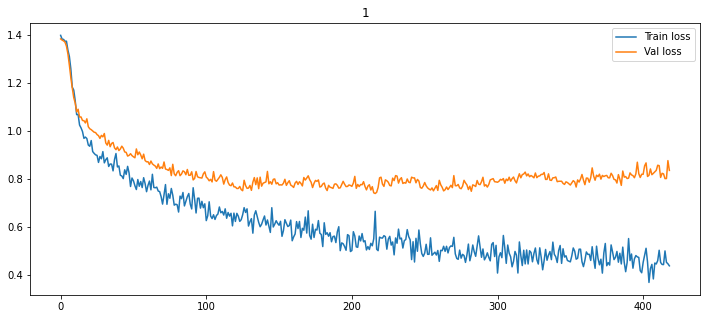

Final results:
{
    "uid": "1",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.9246395806028833,
    "val_cohen_kappa_score": 0.5400475812846947,
    "test_cohen_kappa_score": 0.537037037037037,
    "train_balanced_accuracy_score": 0.9438115763546797,
    "val_balanced_accuracy_score": 0.65625,
    "test_balanced_accuracy_score": 0.6527777777777777,
    "train_macro_f1": 0.9430748345222029,
    "val_macro_f1": 0.654147465437788,
    "test_macro_f1": 0.6407429258166721,
    "train_micro_f1": 0.9434782608695652,
    "val_micro_f1": 0.6551724137931034,
    "test_micro_f1": 0.6527777777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       B

  0%|          | 0/1000 [00:00<?, ?it/s]

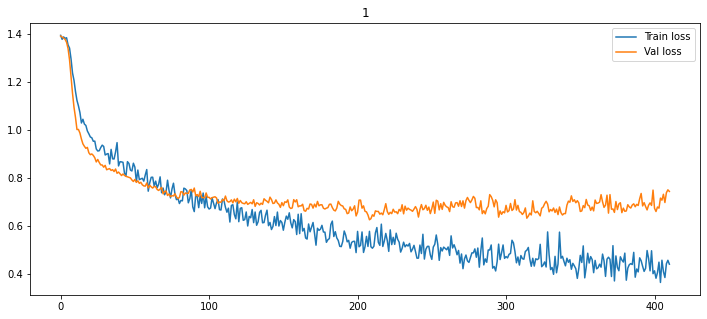

Final results:
{
    "uid": "1",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.9130237482982907,
    "val_cohen_kappa_score": 0.6546248511314013,
    "test_cohen_kappa_score": 0.6574074074074074,
    "train_balanced_accuracy_score": 0.9353860049944211,
    "val_balanced_accuracy_score": 0.7424046541693601,
    "test_balanced_accuracy_score": 0.7430555555555556,
    "train_macro_f1": 0.9357865520968942,
    "val_macro_f1": 0.7430760368663594,
    "test_macro_f1": 0.7407400633000575,
    "train_micro_f1": 0.9347826086956522,
    "val_micro_f1": 0.7413793103448276,
    "test_micro_f1": 0.7430555555555556
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

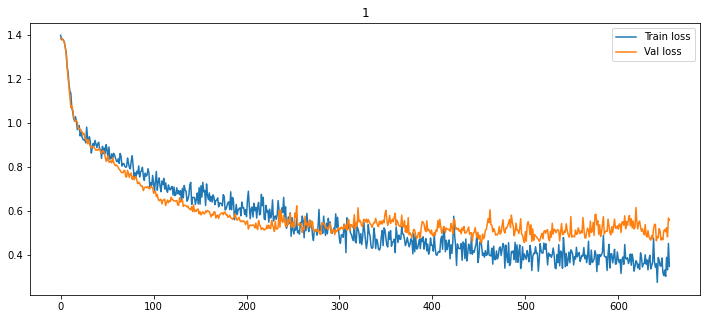

Final results:
{
    "uid": "1",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.9420275243232343,
    "val_cohen_kappa_score": 0.7696584590945195,
    "test_cohen_kappa_score": 0.6481481481481481,
    "train_balanced_accuracy_score": 0.9565755683507691,
    "val_balanced_accuracy_score": 0.8250377073906485,
    "test_balanced_accuracy_score": 0.7361111111111112,
    "train_macro_f1": 0.9561915068159492,
    "val_macro_f1": 0.8223610232623515,
    "test_macro_f1": 0.7321500389374405,
    "train_micro_f1": 0.9565217391304348,
    "val_micro_f1": 0.8275862068965517,
    "test_micro_f1": 0.7361111111111113
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

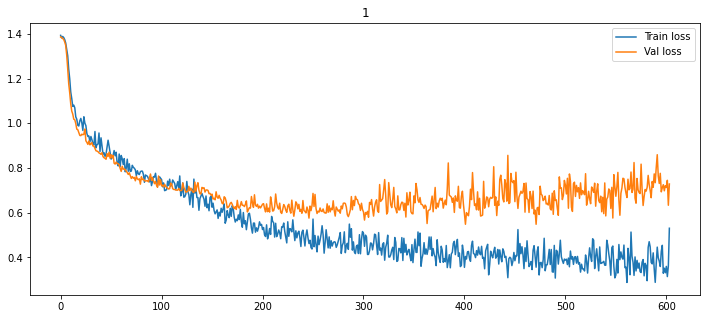

Final results:
{
    "uid": "1",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.9653612575912829,
    "val_cohen_kappa_score": 0.6263826300696437,
    "test_cohen_kappa_score": 0.6435185185185186,
    "train_balanced_accuracy_score": 0.9745689655172415,
    "val_balanced_accuracy_score": 0.7212885154061625,
    "test_balanced_accuracy_score": 0.7326388888888888,
    "train_macro_f1": 0.9743830048836083,
    "val_macro_f1": 0.7200255427841635,
    "test_macro_f1": 0.7327443572697894,
    "train_micro_f1": 0.974025974025974,
    "val_micro_f1": 0.7192982456140351,
    "test_micro_f1": 0.7326388888888888
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

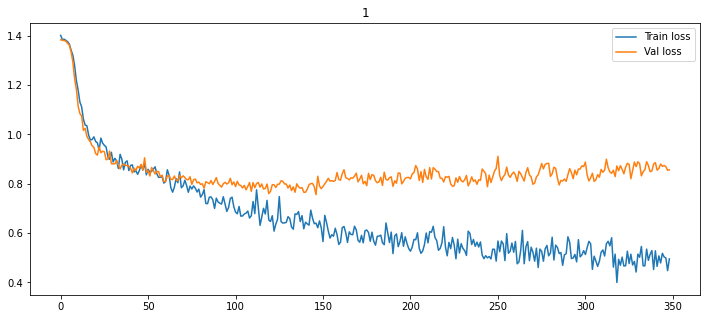

Final results:
{
    "uid": "1",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.8324998749812472,
    "val_cohen_kappa_score": 0.5130187144019528,
    "test_cohen_kappa_score": 0.625,
    "train_balanced_accuracy_score": 0.8722929174857872,
    "val_balanced_accuracy_score": 0.6500484809308339,
    "test_balanced_accuracy_score": 0.71875,
    "train_macro_f1": 0.871697558555252,
    "val_macro_f1": 0.625003078817734,
    "test_macro_f1": 0.7076671672745478,
    "train_micro_f1": 0.8744588744588745,
    "val_micro_f1": 0.631578947368421,
    "test_micro_f1": 0.71875
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/345711 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/338285 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

  0%|          | 0/1000 [00:00<?, ?it/s]

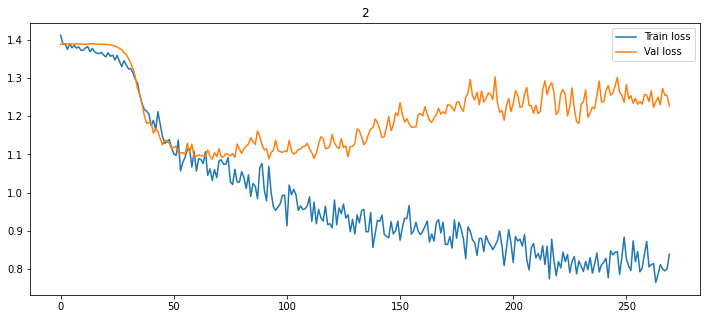

Final results:
{
    "uid": "2",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.5190224237843286,
    "val_cohen_kappa_score": 0.3790642347343378,
    "test_cohen_kappa_score": 0.26388888888888884,
    "train_balanced_accuracy_score": 0.640426497277677,
    "val_balanced_accuracy_score": 0.5321428571428571,
    "test_balanced_accuracy_score": 0.44791666666666663,
    "train_macro_f1": 0.6341939586645469,
    "val_macro_f1": 0.5152275442598023,
    "test_macro_f1": 0.42259537165350664,
    "train_micro_f1": 0.6391304347826087,
    "val_micro_f1": 0.5344827586206896,
    "test_micro_f1": 0.4479166666666667
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]          

  0%|          | 0/1000 [00:00<?, ?it/s]

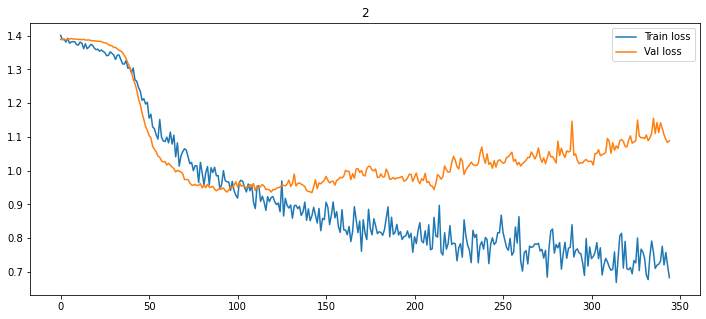

Final results:
{
    "uid": "2",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.7332526536066359,
    "val_cohen_kappa_score": 0.4480570975416336,
    "test_cohen_kappa_score": 0.29166666666666663,
    "train_balanced_accuracy_score": 0.800187969924812,
    "val_balanced_accuracy_score": 0.590625,
    "test_balanced_accuracy_score": 0.46875,
    "train_macro_f1": 0.7972355103111488,
    "val_macro_f1": 0.5795558608058609,
    "test_macro_f1": 0.43278043867067145,
    "train_micro_f1": 0.8000000000000002,
    "val_micro_f1": 0.5862068965517241,
    "test_micro_f1": 0.46875
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5      

  0%|          | 0/1000 [00:00<?, ?it/s]

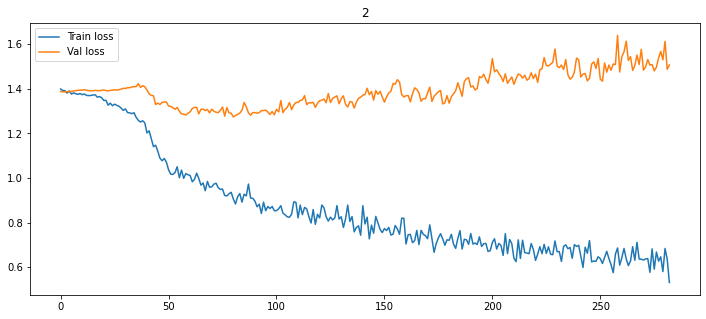

Final results:
{
    "uid": "2",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.6180171112229491,
    "val_cohen_kappa_score": 0.2830940988835725,
    "test_cohen_kappa_score": 0.32407407407407407,
    "train_balanced_accuracy_score": 0.7125,
    "val_balanced_accuracy_score": 0.4767156862745099,
    "test_balanced_accuracy_score": 0.4930555555555556,
    "train_macro_f1": 0.7026508252219696,
    "val_macro_f1": 0.42467981125716214,
    "test_macro_f1": 0.47102955950626463,
    "train_micro_f1": 0.7130434782608696,
    "val_micro_f1": 0.46551724137931033,
    "test_micro_f1": 0.4930555555555556
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
   

  0%|          | 0/1000 [00:00<?, ?it/s]

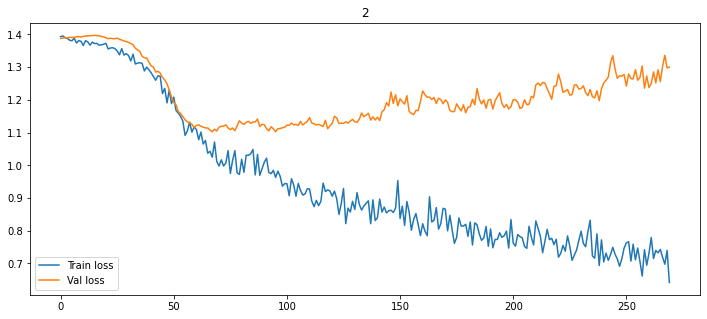

Final results:
{
    "uid": "2",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.5308997919121519,
    "val_cohen_kappa_score": 0.1688942891859051,
    "test_cohen_kappa_score": 0.34259259259259256,
    "train_balanced_accuracy_score": 0.6454815775957614,
    "val_balanced_accuracy_score": 0.3759238310708899,
    "test_balanced_accuracy_score": 0.5069444444444444,
    "train_macro_f1": 0.6338358167169564,
    "val_macro_f1": 0.3476568167529138,
    "test_macro_f1": 0.46812238759326535,
    "train_micro_f1": 0.6493506493506493,
    "val_micro_f1": 0.3684210526315789,
    "test_micro_f1": 0.5069444444444444
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]          

  0%|          | 0/1000 [00:00<?, ?it/s]

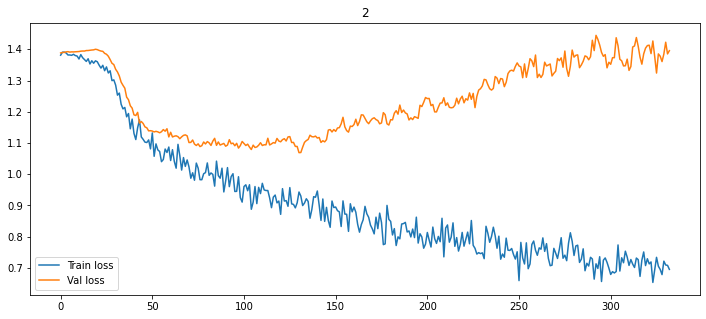

Final results:
{
    "uid": "2",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.6423344904227954,
    "val_cohen_kappa_score": 0.3434800493624024,
    "test_cohen_kappa_score": 0.3287037037037037,
    "train_balanced_accuracy_score": 0.7332866795861659,
    "val_balanced_accuracy_score": 0.49441391941391943,
    "test_balanced_accuracy_score": 0.4965277777777778,
    "train_macro_f1": 0.7216127415891195,
    "val_macro_f1": 0.48884259259259266,
    "test_macro_f1": 0.4792196494264022,
    "train_micro_f1": 0.7316017316017315,
    "val_micro_f1": 0.5087719298245614,
    "test_micro_f1": 0.4965277777777778
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/337191 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/331173 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

  0%|          | 0/1000 [00:00<?, ?it/s]

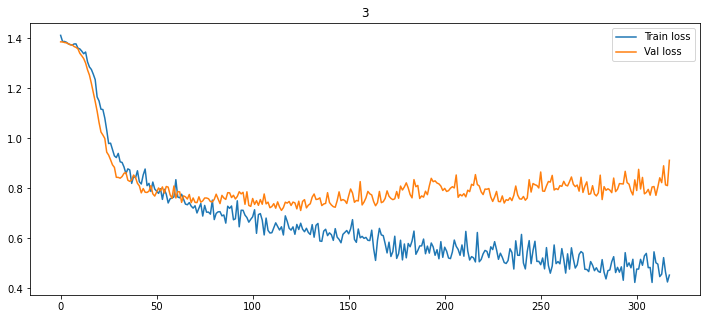

Final results:
{
    "uid": "3",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.8027792489470631,
    "val_cohen_kappa_score": 0.6102766798418973,
    "test_cohen_kappa_score": 0.6435185185185186,
    "train_balanced_accuracy_score": 0.8511796733212341,
    "val_balanced_accuracy_score": 0.7130952380952381,
    "test_balanced_accuracy_score": 0.7326388888888888,
    "train_macro_f1": 0.839645652593021,
    "val_macro_f1": 0.6719790066564261,
    "test_macro_f1": 0.6982358950180731,
    "train_micro_f1": 0.8521739130434782,
    "val_micro_f1": 0.7068965517241379,
    "test_micro_f1": 0.7326388888888888
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             

  0%|          | 0/1000 [00:00<?, ?it/s]

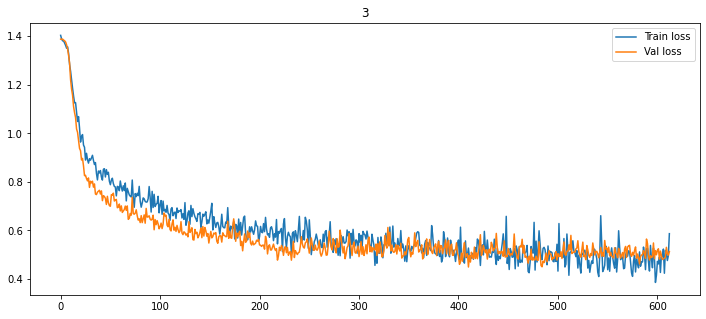

Final results:
{
    "uid": "3",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.8492981527683274,
    "val_cohen_kappa_score": 0.7916167664670659,
    "test_cohen_kappa_score": 0.5925925925925926,
    "train_balanced_accuracy_score": 0.8866228070175438,
    "val_balanced_accuracy_score": 0.8427083333333334,
    "test_balanced_accuracy_score": 0.6944444444444444,
    "train_macro_f1": 0.8809844961229518,
    "val_macro_f1": 0.8454936267436268,
    "test_macro_f1": 0.6706130358238972,
    "train_micro_f1": 0.8869565217391304,
    "val_micro_f1": 0.8448275862068967,
    "test_micro_f1": 0.6944444444444444
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

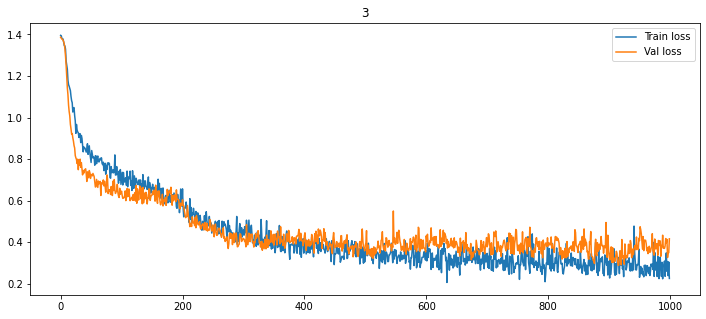

Final results:
{
    "uid": "3",
    "fold_number": 2,
    "train_cohen_kappa_score": 1.0,
    "val_cohen_kappa_score": 0.8841390331602077,
    "test_cohen_kappa_score": 0.712962962962963,
    "train_balanced_accuracy_score": 1.0,
    "val_balanced_accuracy_score": 0.9142156862745098,
    "test_balanced_accuracy_score": 0.7847222222222221,
    "train_macro_f1": 1.0,
    "val_macro_f1": 0.9117335115864528,
    "test_macro_f1": 0.7777323487626788,
    "train_micro_f1": 1.0,
    "val_micro_f1": 0.9137931034482759,
    "test_micro_f1": 0.7847222222222222
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]         

  0%|          | 0/1000 [00:00<?, ?it/s]

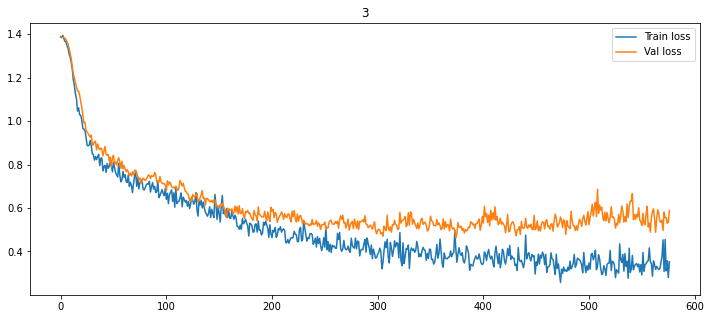

Final results:
{
    "uid": "3",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.9769034644803279,
    "val_cohen_kappa_score": 0.7879288962381149,
    "test_cohen_kappa_score": 0.8287037037037037,
    "train_balanced_accuracy_score": 0.982883923985619,
    "val_balanced_accuracy_score": 0.836896681749623,
    "test_balanced_accuracy_score": 0.8715277777777777,
    "train_macro_f1": 0.982925991720677,
    "val_macro_f1": 0.8358638141246837,
    "test_macro_f1": 0.8666938177510124,
    "train_micro_f1": 0.9826839826839827,
    "val_micro_f1": 0.8421052631578947,
    "test_micro_f1": 0.8715277777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             17

  0%|          | 0/1000 [00:00<?, ?it/s]

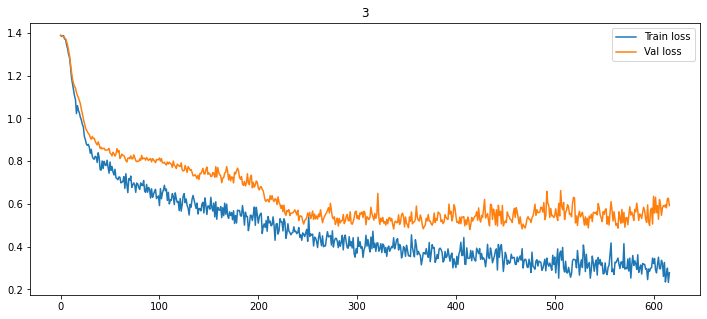

Final results:
{
    "uid": "3",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.9653655854865311,
    "val_cohen_kappa_score": 0.7894088669950738,
    "test_cohen_kappa_score": 0.7407407407407407,
    "train_balanced_accuracy_score": 0.9739866908650937,
    "val_balanced_accuracy_score": 0.8424908424908425,
    "test_balanced_accuracy_score": 0.8055555555555556,
    "train_macro_f1": 0.9738612836438924,
    "val_macro_f1": 0.8436813186813187,
    "test_macro_f1": 0.7978269169558857,
    "train_micro_f1": 0.974025974025974,
    "val_micro_f1": 0.8421052631578947,
    "test_micro_f1": 0.8055555555555556
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/306668 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/336944 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

  0%|          | 0/1000 [00:00<?, ?it/s]

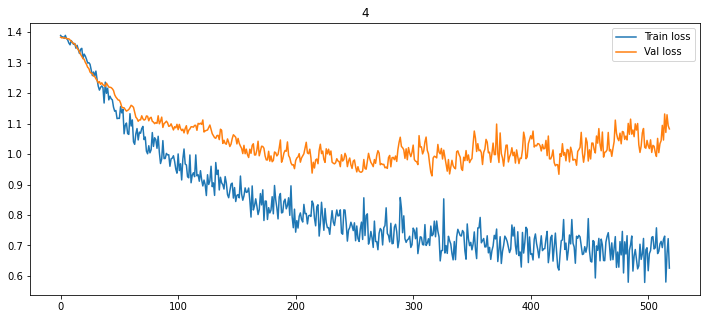

Final results:
{
    "uid": "4",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.8319221852635823,
    "val_cohen_kappa_score": 0.47021445591739475,
    "test_cohen_kappa_score": 0.33333333333333337,
    "train_balanced_accuracy_score": 0.874243799153055,
    "val_balanced_accuracy_score": 0.6023809523809524,
    "test_balanced_accuracy_score": 0.5,
    "train_macro_f1": 0.8728352455625183,
    "val_macro_f1": 0.6063237837431386,
    "test_macro_f1": 0.49612069696815464,
    "train_micro_f1": 0.8739130434782608,
    "val_micro_f1": 0.603448275862069,
    "test_micro_f1": 0.5
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5    

  0%|          | 0/1000 [00:00<?, ?it/s]

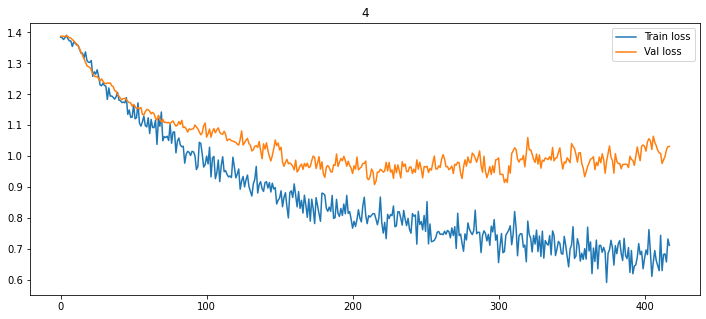

Final results:
{
    "uid": "4",
    "fold_number": 1,
    "train_cohen_kappa_score": 0.8202989137283565,
    "val_cohen_kappa_score": 0.4491491887613771,
    "test_cohen_kappa_score": 0.37037037037037035,
    "train_balanced_accuracy_score": 0.8664317042606515,
    "val_balanced_accuracy_score": 0.590625,
    "test_balanced_accuracy_score": 0.5277777777777778,
    "train_macro_f1": 0.8662070558622283,
    "val_macro_f1": 0.5753917050691245,
    "test_macro_f1": 0.524896067163509,
    "train_micro_f1": 0.8652173913043477,
    "val_micro_f1": 0.5862068965517241,
    "test_micro_f1": 0.5277777777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
     

  0%|          | 0/1000 [00:00<?, ?it/s]

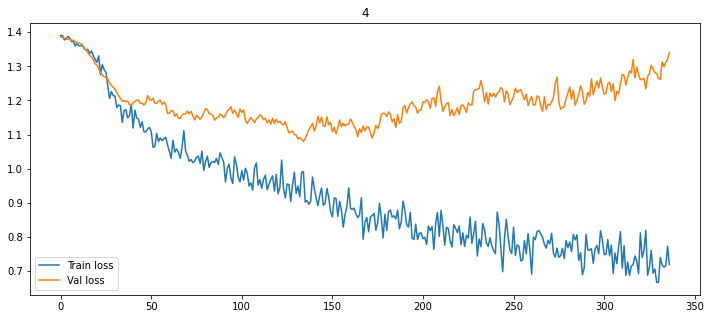

Final results:
{
    "uid": "4",
    "fold_number": 2,
    "train_cohen_kappa_score": 0.7044148775325068,
    "val_cohen_kappa_score": 0.31007137192704204,
    "test_cohen_kappa_score": 0.3287037037037037,
    "train_balanced_accuracy_score": 0.7789919714540589,
    "val_balanced_accuracy_score": 0.482051282051282,
    "test_balanced_accuracy_score": 0.4965277777777778,
    "train_macro_f1": 0.7800979262672811,
    "val_macro_f1": 0.471031746031746,
    "test_macro_f1": 0.49058688274640966,
    "train_micro_f1": 0.7782608695652173,
    "val_micro_f1": 0.4827586206896552,
    "test_micro_f1": 0.4965277777777778
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]            

  0%|          | 0/1000 [00:00<?, ?it/s]

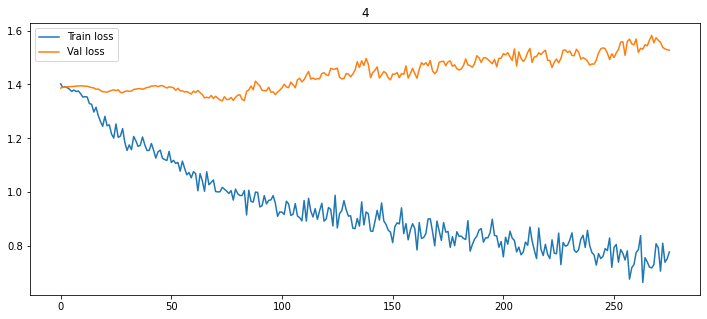

Final results:
{
    "uid": "4",
    "fold_number": 3,
    "train_cohen_kappa_score": 0.5660831016605304,
    "val_cohen_kappa_score": 0.19001218026796585,
    "test_cohen_kappa_score": 0.3564814814814815,
    "train_balanced_accuracy_score": 0.6707029382073216,
    "val_balanced_accuracy_score": 0.3998868778280543,
    "test_balanced_accuracy_score": 0.517361111111111,
    "train_macro_f1": 0.6605353882443665,
    "val_macro_f1": 0.38060200668896327,
    "test_macro_f1": 0.4840489291668436,
    "train_micro_f1": 0.6753246753246753,
    "val_micro_f1": 0.38596491228070173,
    "test_micro_f1": 0.5173611111111112
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]          

  0%|          | 0/1000 [00:00<?, ?it/s]

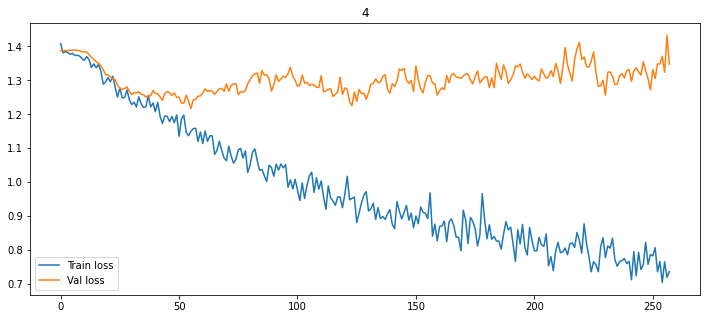

Final results:
{
    "uid": "4",
    "fold_number": 4,
    "train_cohen_kappa_score": 0.4853817271589487,
    "val_cohen_kappa_score": 0.12343180898421702,
    "test_cohen_kappa_score": 0.2870370370370371,
    "train_balanced_accuracy_score": 0.6127760499290307,
    "val_balanced_accuracy_score": 0.34666895604395603,
    "test_balanced_accuracy_score": 0.4652777777777778,
    "train_macro_f1": 0.6012838468720823,
    "val_macro_f1": 0.30355937921727394,
    "test_macro_f1": 0.44054071175178783,
    "train_micro_f1": 0.6147186147186147,
    "val_micro_f1": 0.3333333333333333,
    "test_micro_f1": 0.4652777777777778
}


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/350293 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/347090 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


SHAPE (288, 22, 270)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

  0%|          | 0/1000 [00:00<?, ?it/s]

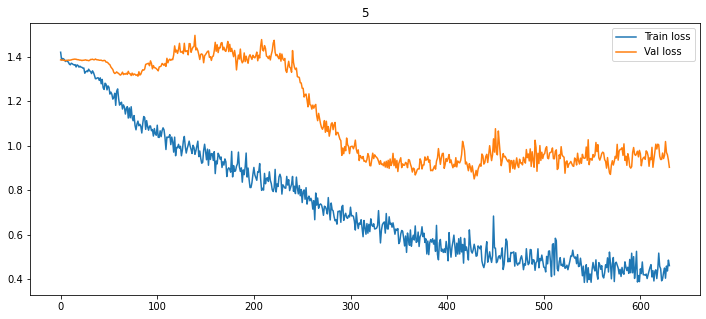

Final results:
{
    "uid": "5",
    "fold_number": 0,
    "train_cohen_kappa_score": 0.9130478614814628,
    "val_cohen_kappa_score": 0.5870253164556962,
    "test_cohen_kappa_score": 0.38888888888888884,
    "train_balanced_accuracy_score": 0.9348154869933454,
    "val_balanced_accuracy_score": 0.6916666666666667,
    "test_balanced_accuracy_score": 0.5416666666666666,
    "train_macro_f1": 0.9338418953594445,
    "val_macro_f1": 0.6828476084538376,
    "test_macro_f1": 0.5393945746110089,
    "train_micro_f1": 0.9347826086956522,
    "val_micro_f1": 0.6896551724137931,
    "test_micro_f1": 0.5416666666666666
}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]           

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
import numpy as np
import mne
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch import nn
from torchsummary import summary
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from ica_benchmark.processing.ica import get_ica_instance
from copy import deepcopy
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)
random_state = 1

mne.set_log_level(0)
bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')
# raw_fn = lambda raw: apply_raw(exponential_standardize, raw)
raw_fn = lambda raw: apply_raw(process_raw_fn, raw.copy().resample(128))

dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)

fold_sizes = None


splitter = Splitter(
    dataset,
    uids=dataset.list_uids(),
#     uids=["8"],
    sessions=dataset.SESSIONS,
    runs=dataset.RUNS,
    load_kwargs=dict(
        reject=False,
        tmin=0.5,
        tmax=2.6,
        raw_fn=raw_fn,
        concatenate=False
    ),
    splitter=KFold(4),
    intra_session_shuffle=False,
    fold_sizes=fold_sizes,
)
splits_iterable = splitter.yield_splits_epochs(mode="inter_session")
results = list()
ICA = get_ica_instance("ext_infomax")

for i, fold_splits in enumerate(splits_iterable):
    
    uid = fold_splits[0]["uid"][0]
    
    train_epochs, test_epochs = splitter.load_from_splits(fold_splits, fold_sizes=None)
    if isinstance(train_epochs, (list, tuple)):
        train_epochs = train_epochs[0].load_data()
        test_epochs = test_epochs[0].load_data()
        
    n_channels = len(train_epochs.ch_names)
    
    ICA.fit(train_epochs)
    train_epochs = ICA.transform(train_epochs)
    test_epochs = ICA.transform(test_epochs)
    
    print("SHAPE", train_epochs.get_data().shape)
    train_data = train_epochs.get_data()[..., :256]
    test_data = test_epochs.get_data()[..., :256]
    train_labels = train_epochs.events[:, 2]
    test_labels = test_epochs.events[:, 2]
    
    del train_epochs, test_epochs


    train_data = np.expand_dims(train_data, axis=1)
    test_data = np.expand_dims(test_data, axis=1)
    
    full_train_data, full_train_labels = torch.from_numpy(train_data).float(), torch.from_numpy(train_labels).to(dtype=torch.int64)
    test_data, test_labels = torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).to(dtype=torch.int64)
    
    test_dataset = TensorDataset(test_data, test_labels)
    
    for fold_number, (train_idx, val_idx) in enumerate(KFold(5).split(full_train_data)):
    
        train_data = full_train_data[train_idx]
        train_labels = full_train_labels[train_idx]
        val_data = full_train_data[val_idx]
        val_labels = full_train_labels[val_idx]
    
        train_dataset = TensorDataset(train_data, train_labels)

        train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

        torch.manual_seed(random_state)
        model = EEGNet(n_channels, 4, 256).float()
        summary(model, input_size=(1, n_channels, 256), device="cpu")

        criterion = nn.CrossEntropyLoss()

        model.train()
        best_state = None
        best_val_loss = 1000
        patience = 0
        max_patience = 200
        min_delta = 1e-3

        train_losses = list()
        val_losses = list()
        pbar = tqdm(range(1000))
        for epoch in pbar:

            optim = Adam(model.parameters(), lr=1e-3)

            epoch_loss = 0
            epoch_loss_after_norm = 0
            model.train()
            for batch_number, (batch_x, batch_y) in enumerate(train_dataloader):
                optim.zero_grad()

                pred = model(batch_x)
                loss = criterion(pred, batch_y)
                epoch_loss += loss.item() / len(train_dataloader)

                loss.backward()
                optim.step()

                # Projection to norm constraints
                model.apply_constraints()

                epoch_loss_after_norm += criterion(model(batch_x), batch_y).item() / len(train_dataloader)

            model.eval()
            val_loss = criterion(
                model(val_data),
                val_labels
            ).item()

            train_losses.append(epoch_loss)
            val_losses.append(val_loss)

            pbar.set_description("{}-{}/{}) T:{:.3f} -> {:.3f} | V:{:.3f} (Best: {:.3f})".format(epoch, patience, max_patience, epoch_loss, epoch_loss_after_norm, val_loss, best_val_loss))

            if (best_val_loss - val_loss) > min_delta:
                best_state = deepcopy(model.state_dict())
                best_val_loss = val_loss
                patience = 0
            elif patience > max_patience:
                break
            else:
                patience += 1

        model.load_state_dict(best_state)
        model.eval()

        metric_dict = dict(
            uid=uid,
            fold_number=fold_number,
        )
        
        def macro_f1(a, b):
            return f1_score(a, b, average="macro")

        def micro_f1(a, b):
            return f1_score(a, b, average="micro")
        
        for metric_fn in (cohen_kappa_score, balanced_accuracy_score, macro_f1, micro_f1):
            train_metric = metric_fn(
                train_labels,
                model(train_data).detach().numpy().argmax(axis=1)
            )
            val_metric = metric_fn(
                val_labels,
                model(val_data).detach().numpy().argmax(axis=1)
            )
            test_metric = metric_fn(
                test_labels,
                model(test_data).detach().numpy().argmax(axis=1)
            )
            metric_name = metric_fn.__name__
            metric_dict.update(
                {
                    f"train_{metric_name}": train_metric,
                    f"val_{metric_name}": val_metric,
                    f"test_{metric_name}": test_metric
                }
            )

        results.append(metric_dict)

        plt.figure(figsize=(12, 5))
        plt.title(uid)
        plt.plot(range(len(train_losses)), train_losses, label="Train loss")
        plt.plot(range(len(val_losses)), val_losses, label="Val loss")
        plt.legend()
        plt.show()

        print("Final results:")
        print(json.dumps(metric_dict, indent=4))

In [47]:
pd.DataFrame.from_records(results).to_csv("5_fold_ica_eegnet.csv")

In [49]:
pd.read_csv("5_fold_ica_eegnet.csv", index_col=0).groupby("uid").describe().test_balanced_accuracy_score

count      mean       std       min       25%       50%       75%  \
uid                                                                      
1      5.0  0.716667  0.036796  0.652778  0.718750  0.732639  0.736111   
2      5.0  0.482639  0.023931  0.447917  0.468750  0.493056  0.496528   
3      5.0  0.777778  0.068174  0.694444  0.732639  0.784722  0.805556   
4      5.0  0.501389  0.023880  0.465278  0.496528  0.500000  0.517361   
5      1.0  0.541667       NaN  0.541667  0.541667  0.541667  0.541667   

          max  
uid            
1    0.743056  
2    0.506944  
3    0.871528  
4    0.527778  
5    0.541667

'0.12.2'

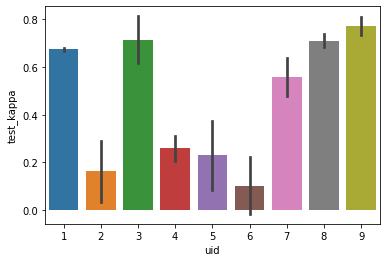

In [4]:
import seaborn as sns
import pandas as pd

d = pd.read_csv("4_fold_eegnet.csv")
sns.barplot(x=d.uid, y=d.test_kappa, errorbar="sd")
sns.__version__

In [43]:
!pip install --upgrade seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self, 
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 dilation=1,
                 bias=False,
                 padding="same",
                 padding_mode='zeros',
                 depth_multiplier=1,
        ):
        super(SeparableConv2d, self).__init__()
        # 16 * D * F1
        self.depthwise_layer = nn.Conv2d(
            in_channels, 
            depth_multiplier * in_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            dilation=1,
            stride=1,
            padding=padding,
            padding_mode=padding_mode,
            bias=bias
        )
        # F2 * D * F1
        self.pointwise_layer = nn.Conv2d(
            depth_multiplier * in_channels,
            out_channels,
            kernel_size=(1, 1),
            groups=1,
            dilation=1,
            stride=1,
            padding=padding,
            padding_mode=padding_mode,
            bias=bias
        )

    def forward(self, x):
        depthwise_output = self.depthwise_layer(x)
        pointwise_output = self.pointwise_layer(depthwise_output)
        return pointwise_output

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    
    def forward(self, x):
        return x.reshape(self.shape)

class ExpandDims(nn.Module):
    def __init__(self, dim=0):
        super(ExpandDims, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        if x.ndim == 2:
            # For C, T
            x = x.unsqueeze(0).unsqueeze(0)
        elif x.ndim == 3:
            # For N, C, T
            x = x.unsqueeze(1)
        return x

def _glorot_weight_zero_bias(model):
    """Initalize parameters of all modules by initializing weights with
    glorot
     uniform/xavier initialization, and setting biases to zero. Weights from
     batch norm layers are set to 1.
    Parameters
    ----------
    model: Module
    """
    for module in model.modules():
        if hasattr(module, "weight"):
            if not ("BatchNorm" in module.__class__.__name__):
                nn.init.xavier_uniform_(module.weight, gain=1)
            else:
                nn.init.constant_(module.weight, 1)
        if hasattr(module, "bias"):
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)


def temporal_filter_init(weight):
    with torch.no_grad():
        new_weights = torch.zeros_like(weight)
        new_weights[..., -1] = 1
        weight.copy_(new_weights)
        

def spatial_filter_init(weight):
    with torch.no_grad():
        n_channels = weight.size(2)
        new_weights = torch.ones_like(weight) / n_channels
        weight.copy_(new_weights)

        
class DeepConvNet(nn.Module):
    
    
    def __init__(self, n_channels, n_classes, length, *, f1=4, d=2, f2=8, p=.5, spatial_filter=True):
        super(EEGNet, self).__init__()
        self.f1 = f1
        self.d = d
        self.f2 = f2
        self.p = p
        self.length = length
        
        n_classes = 1 if (n_classes <= 2) else n_classes
        
        self.depthwiseconv2d = nn.Conv2d(f1, d * f1, (n_channels, 1), groups=f1, padding="valid", bias=False)
        self.first_block_top = nn.Sequential(
            OrderedDict(
                conv2d=nn.Conv2d(1, f1, (1, 64), padding="same", bias=False),
                batchnorm=nn.BatchNorm2d(f1, 1e-5),
                depthwiseconv2d=self.depthwiseconv2d
            )
        )
        
        self.first_block_bottom = nn.Sequential(
            OrderedDict(
                batchnorm=nn.BatchNorm2d(f1 * d, 1e-5),
                activation=nn.ELU(),
                avgpool2d=nn.AvgPool2d((1, 4), 4),
                dropout=nn.Dropout(p),
            )
        )
        
        self.second_block = nn.Sequential(
            OrderedDict(
#             SeparableConv2d(f1 * d, f2, (1, 16), bias=False),
                separableconv2d=SeparableConv2d(
                    d * f1,
                    f2,
                    kernel_size=(1, 16),
                    bias=False,
                    padding="same",
                    depth_multiplier=1
                ),
                batchnorm=nn.BatchNorm2d(f2, 1e-5),
                activation=nn.ELU(),
                avgpool2d=nn.AvgPool2d((1, 8), 8),
                dropout=nn.Dropout(p),
            )
        )
        
        self.classifier = nn.Sequential(
            OrderedDict(
                flatten=nn.Flatten(),
                linear=nn.Linear(f2 * length // 32, n_classes),
#                 activation=nn.Sigmoid() if (n_classes == 1) else nn.Softmax(dim=1)
            )
        )
        _glorot_weight_zero_bias(self)
        temporal_filter_init(self.first_block_top.conv2d.weight)
        spatial_filter_init(self.first_block_top.depthwiseconv2d.weight)

    def apply_constraints(self, max_filter_norm=1., max_clf_norm=.25):
        apply_max_norm(self.depthwiseconv2d.weight, dim=2, max_value=max_filter_norm)
        apply_max_norm(self.classifier[1].weight, dim=1, max_value=max_clf_norm)
    
    def forward(self, x):
        output = self.first_block_top(x)
        output = self.first_block_bottom(output)
        output = self.second_block(output)
        output = self.classifier(output)
        return output

f1 = 4
d = 2
f2 = 8
n_channels = 22
length = 256
n_classes = 4

shape = (1, n_channels, 256)
model = EEGNet(n_channels, n_classes, length, f1=f1, f2=f2, d=d).to("cpu").float()
r = model.forward(torch.rand(100, 1, n_channels, length))
print(r.shape)
# display(model)

summary(model, input_size=shape, device="cpu")
